In [ ]:
# @title 1. Install Dependencies (Revised)

# --- Install Conflicting Dependencies
print("\nInstalling specific versions for compatibility...")

!pip install "numpy>=2.0,<2.1" pandas==2.2.2 "rich<14" -q

# --- Core ML Libraries ---
print("\nInstalling core ML libraries...")
# Keep torch 2.3.1
!pip install torch==2.3.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q

!pip install transformers==4.43.3 -q

!pip install datasets==2.19.0 -q

!pip install accelerate==0.30.1 bitsandbytes==0.43.1 -q

# --- Other Utilities ---
print("\nInstalling other utilities...")
!pip install --upgrade packaging -q
!pip install --upgrade gradio termcolor tqdm huggingface_hub -q

print("\n--- Dependency Installation Attempted ---")



Installing specific versions for compatibility...

Installing core ML libraries...

Installing other utilities...

--- Dependency Installation Attempted ---
NOTE: Using NumPy>=2.0, pinned pandas==2.2.2, rich<14.
Keeping transformers==4.43.3, datasets==2.19.0.
Hoping this combination resolves conflicts.
Please check the output carefully and proceed to the next cell (Imports/Checks).


In [ ]:
# @title 2. Version Checks & Imports
import torch
import transformers
import datasets
import gradio as gr
# import flash_attn # REMOVED Check if flash_attn imported okay

# --- Standard Libraries ---
import time
import gc
import abc
import os
import numpy as np
import pandas as pd
import getpass
from math import inf
from typing import List, Tuple, Optional, Dict, Union, Any

# --- Utilities ---
from termcolor import colored
from rich.console import Console
from tqdm.auto import tqdm
from huggingface_hub import login, HfFolder

# --- PyTorch Core ---
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Module

# --- Transformers Components ---
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GenerationConfig,
    BitsAndBytesConfig,
    StoppingCriteria,
    LogitsProcessor,
    LogitsProcessorList,
)
from transformers.generation.stopping_criteria import StoppingCriteriaList
from transformers.generation.logits_process import (
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper
)
from transformers.cache_utils import DynamicCache, Cache

# --- Local Utilities (including GPUMonitor) ---
import pynvml
import threading

# --- Version Checks ---
print(f"\n--- Version Information ---")
!python --version
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA Version detected by PyTorch: {torch.version.cuda}")
    print(f"cuDNN Version detected by PyTorch: {torch.backends.cudnn.version()}")
else:
    print("CUDA not available according to PyTorch.")
print(f"Transformers Version: {transformers.__version__}")
print(f"Datasets Version: {datasets.__version__}")
print(f"Gradio Version: {gr.__version__}")
# try: # REMOVED Flash Attn Check
#     print(f"Flash Attention version: {flash_attn.__version__}")
#     FLASH_ATTN_AVAILABLE = True
# except NameError:
#     print("Flash Attention not imported.")
FLASH_ATTN_AVAILABLE = False # Set to False since we removed it
# except Exception as e:
#     print(f"Flash Attention check failed: {e}")
#     FLASH_ATTN_AVAILABLE = False
print("Flash Attention Available:", FLASH_ATTN_AVAILABLE) # Indicate it's not used
print("-------------------------\n")


# --- Initial Cleanup ---
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Imports and checks complete.")


--- Version Information ---
Python 3.11.12
PyTorch Version: 2.3.1+cu121
CUDA Version detected by PyTorch: 12.1
cuDNN Version detected by PyTorch: 8902
Transformers Version: 4.43.3
Datasets Version: 2.19.0
Gradio Version: 5.28.0
Flash Attention Available: False
-------------------------

Imports and checks complete.


In [ ]:
# @title 2.5. Mount Google Drive & Define Save Path
from google.colab import drive
import os

try:
    drive.mount('/content/drive')
    # Define a CHECKPOINT_DIR within your Google Drive
    # MODIFY THIS PATH if you prefer a different location
    DRIVE_SAVE_DIR = "/content/drive/MyDrive/DecodingBenchmarkResults"
    os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
    print(f"Google Drive mounted. Results will be saved to: {DRIVE_SAVE_DIR}")
    # Update the global CHECKPOINT_DIR used later
    CHECKPOINT_DIR = DRIVE_SAVE_DIR
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Results will be saved to the local Colab environment directory './checkpoints'.")
    # Fallback to local directory if Drive mount fails
    CHECKPOINT_DIR = "./checkpoints" # Keep the original fallback
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)


print(f"Checkpoint directory set to: {CHECKPOINT_DIR}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted. Results will be saved to: /content/drive/MyDrive/DecodingBenchmarkResults
Checkpoint directory set to: /content/drive/MyDrive/DecodingBenchmarkResults


In [ ]:
# @title 3. Configuration

# --- Hugging Face Authentication Setup ---

print("Attempting to clear any existing Hugging Face CLI login...")
!huggingface-cli logout
from huggingface_hub import logout as hf_logout
try:
    hf_logout()
    print("Cleared Hugging Face library login state.")
except Exception as e:
    print(f"Could not clear library login state: {e}")
# ***********************************

# --- Hugging Face Authentication Setup ---
# Try to get HF_TOKEN from environment variables or saved login first
HF_TOKEN = os.environ.get('HF_TOKEN') or HfFolder.get_token()

if not HF_TOKEN:
    print("Hugging Face token not found in environment variables or saved cache.")
    print("You need to authenticate to access Llama models.")
    print("Visit https://huggingface.co/settings/tokens to create a token if you don't have one.")
    HF_TOKEN = getpass.getpass("Enter your Hugging Face token: ")

# Login to Hugging Face
if HF_TOKEN:
    try:
      login(token=HF_TOKEN)
      print("Successfully logged in to Hugging Face via login()!")
      print("Verifying login identity via CLI:")
      !huggingface-cli whoami
      # **************************
    except Exception as e:
      print(f"Hugging Face login failed: {e}")
      print("Proceeding without login, may fail to load models.")
else:
    print("WARNING: No Hugging Face token provided. You may encounter errors accessing the models.")


Attempting to clear any existing Hugging Face CLI login...
Not logged in!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Not logged in!


Cleared Hugging Face library login state.
Hugging Face token not found in environment variables or saved cache.
You need to authenticate to access Llama models.
Visit https://huggingface.co/settings/tokens to create a token if you don't have one.
Enter your Hugging Face token: ··········
Successfully logged in to Hugging Face via login()!
Verifying login identity via CLI:
katerinaivanovich

--- Configuration Summary ---
Device: cuda
DType: torch.bfloat16
Target Model: meta-llama/Llama-3.1-8B-Instruct
Draft Model (for SD): meta-llama/Llama-3.2-1B-Instruct
Flash Attention Available: False
Quantization Config: Disabled
Default Max New Tokens: 256
SD Gamma: 10
PLD Max N-gram: 3, PLD Num Pred: 5
Sampling: Temp=0, TopK=50, TopP=0.9
---------------------------

Configuration set.


In [ ]:
# --- Model Configuration ---
TARGET_MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
DRAFT_MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# --- Hardware & Precision ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else \
        (torch.float16 if torch.cuda.is_available() else torch.float32)

# --- Quantization Configuration ---
LOAD_IN_4BIT = False # Set to True to enable 4-bit quantization for Target Model
LOAD_IN_8BIT = False # Set to True to enable 8-bit quantization for Target Model
quantization_config = None
if LOAD_IN_4BIT:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=DTYPE,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )
    print("Using 4-bit quantization for Target Model.")
elif LOAD_IN_8BIT:
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    print("Using 8-bit quantization for Target Model.")

# --- Decoding Parameters ---
DEFAULT_MAX_NEW_TOKENS = 256 # Max tokens to generate
UI_MAX_NEW_TOKENS_LIMIT = 1024
# Speculative Decoding (SD)
DEFAULT_GAMMA = 3 # Number of draft tokens for SD
# Prompt Lookup Decoding (PLD)
DEFAULT_MAX_NGRAM_SIZE = 3 # Maximum size of n-grams to search for in PLD
DEFAULT_NUM_PRED_TOKENS = 5 # Number of tokens to predict after match in PLD
# Sampling
DEFAULT_TEMPERATURE = 0
DEFAULT_TOP_K = 50
DEFAULT_TOP_P = 0.9

# --- Benchmarking Parameters ---
BENCHMARK_PROMPTS = [  # Using User's prompts
    "Write a descriptive paragraph about a bustling marketplace, incorporating sensory details such as smells, sounds, and visual elements to create an immersive experience for the reader.",
    "Act as a math teacher. I will provide some mathematical equations or concepts, and it will be your job to explain them in easy-to-understand terms. My first request is \"I need help understanding how probability works.\"",
    "A is the father of B. B is the father of C. What is the relationship between A and C?",
    "Joey plays football every week. Last week he played 2 matches on Monday, 1 match on Friday, and on Saturday he played double the number of matches he played on Monday. How many matches did Joey play in one week?",
    "Given the following data, identify the company with the highest profit in 2021 and provide its CEO's name: a) Company X, with CEO Amy Williams, reported $30 billion in revenue and a $3 billion profit in 2021. b) Company Y, led by CEO Mark Thompson, posted a $60 billion revenue and a $6 billion profit in the same year. c) Company Z, under CEO Sarah Johnson, announced a $20 billion revenue and a $7 billion profit in 2021. d) Company W, managed by CEO James Smith, revealed a $300 billion revenue with a $21 billion profit in 2021. e) Company V, with CEO Lisa Brown, reported a $200 billion revenue and a $25 billion profit in 2021. f) Company U, under CEO John White, posted a $180 billion revenue and a $20 billion profit in the same year.",
    "Where does the song 10 green bottles come from?",
    "Photosynthesis is a vital process for life on Earth. Could you outline the two main stages of photosynthesis, including where they take place within the chloroplast, and the primary inputs and outputs for each stage?",
    """Create a lesson plan that integrates drama, mime or theater techniques into a history class. Duration: 3 class periods (each lasts for 45 minutes) for 3 days
Topic: Opium Wars between China and Britain
Grade level: 9-10""",
    "Translate German to English: Patek kann gegen sein Urteil noch Berufung einlegen.",
    """Summarize: (CNN)Lois Lilienstein, co-star of \"Sharon, Lois & Bram's Elephant Show\" — the Canadian preschool show that ran on Nickelodeon during the early 1990s — has died, aged 78. Her son, David Lilienstein, told CBC News that his mother died in Toronto on Wednesday night from a rare form of cancer first diagnosed last October. \"She knew it was happening, she was at peace with it, and she died very peacefully and not in pain,\" he told the Canadian broadcaster. Liz Smith at 92. Lilienstein was born in Chicago in 1936 and moved to Toronto in 1996 with her son and her husband, Ernest. She joined Sharon Hampson and Bram Morrison to launch their singing trio in 1978. The TV show \"Sharon, Lois & Bram's Elephant Show\" ran on CBC in Canada from 1984 to 1989, before continuing in reruns on Nickelodeon stateside until 1995. The 30 most popular film producers in Hollywood. Sally Catto, general manager, programming at CBC Television, paid tribute to Lilienstein for her contribution to Canadian kids TV. \"Sharon, Lois and Bram got their start at CBC back in the '80s with the Elephant Show, and they went on to become icons to children all across North America through various programs and specials. Lois will be fondly remembered by her many friends at CBC,\" Catto told The Hollywood Reporter. 'Ghostbusters' budget cut. The Canadian variety show was best known for songs like \"Skinnamarink\" and \"Peanut Butter.\" Lilienstein left the Sharon, Lois & Bram performance trio in 2000. ©2015 The Hollywood Reporter. All rights reserved."""
]
BENCHMARK_MAX_NEW_TOKENS = 128 # Reduced for faster benchmarking
BENCHMARK_GAMMA = 3 # Use same gamma as default for SD benchmark
BENCHMARK_PLD_MAX_NGRAM = 3
BENCHMARK_PLD_NUM_PRED = 5
BENCHMARK_RUNS = 1 # Minimum runs per prompt for benchmarking

# --- Checkpointing ---
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"\n--- Configuration Summary ---")
print(f"Device: {DEVICE}")
print(f"DType: {DTYPE}")
print(f"Target Model: {TARGET_MODEL_NAME}")
print(f"Draft Model (for SD): {DRAFT_MODEL_NAME}")
print(f"Flash Attention Available: {FLASH_ATTN_AVAILABLE}")
print(f"Quantization Config: {'Enabled (4-bit)' if LOAD_IN_4BIT else ('Enabled (8-bit)' if LOAD_IN_8BIT else 'Disabled')}")
print(f"Default Max New Tokens: {DEFAULT_MAX_NEW_TOKENS}")
print(f"SD Gamma: {DEFAULT_GAMMA}")
print(f"PLD Max N-gram: {DEFAULT_MAX_NGRAM_SIZE}, PLD Num Pred: {DEFAULT_NUM_PRED_TOKENS}")
print(f"Sampling: Temp={DEFAULT_TEMPERATURE}, TopK={DEFAULT_TOP_K}, TopP={DEFAULT_TOP_P}")
print("---------------------------\n")
print("Configuration set.")



--- Configuration Summary ---
Device: cuda
DType: torch.bfloat16
Target Model: meta-llama/Llama-3.1-8B-Instruct
Draft Model (for SD): meta-llama/Llama-3.2-1B-Instruct
Flash Attention Available: False
Quantization Config: Disabled
Default Max New Tokens: 256
SD Gamma: 3
PLD Max N-gram: 3, PLD Num Pred: 5
Sampling: Temp=0, TopK=50, TopP=0.9
---------------------------

Configuration set.


In [ ]:
# @title 4. Utility Functions & Classes

# --- Console Printing ---
console = Console()
def print_colored(text: str, color: str):
    console.print(colored(text, color))

def print_debug_info(title: str, data: Any, color: str = "yellow"):
    console.print(f"[bold {color}]{title}:[/] {data}")

def format_metrics(metrics: Dict[str, Any]) -> str:
    lines = []
    for key, value in metrics.items():
        if isinstance(value, float):
            lines.append(f"- {key}: {value:.3f}")
        else:
            lines.append(f"- {key}: {value}")
    return "\n".join(lines)

# --- Tokenization Utils ---
def ids_to_string(token_ids: Union[List[int], torch.Tensor, int, None], tokenizer: AutoTokenizer) -> str:
    """Converts token IDs (list, tensor, single int, or None) to a string, skipping special tokens."""

    # --- ADDED NONE CHECK ---
    if token_ids is None:
        return "" # Return empty string if input is None

    if isinstance(token_ids, torch.Tensor):
        # Ensure tensor is on CPU and 1D before converting to list
        if token_ids.numel() == 0:
             return "" # Handle empty tensor
        token_ids = token_ids.squeeze().cpu().tolist()
        # Handle case where squeeze results in a single int (0-dim tensor)
        if isinstance(token_ids, int):
            token_ids = [token_ids]

    elif isinstance(token_ids, int): # Handle single int case
        token_ids = [token_ids]
    elif not isinstance(token_ids, list):
        # Handle unexpected types if necessary, or raise error
        return "[INVALID TYPE]"

    # Filter out None if accidentally present in a list (shouldn't happen with None check above)
    token_ids = [tok for tok in token_ids if tok is not None]

    if not token_ids: # Handle empty list
        return ""

    # Filter out special tokens - adjust based on tokenizer behavior if needed
    # Use error handling in case decode fails
    try:
        return tokenizer.decode(token_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    except Exception as e:
        print(f"Error during tokenizer.decode: {e}, Input IDs: {token_ids}")
        return "[DECODE ERROR]"

# --- Debug Printing for Speculative Steps ---
def print_speculative_step_debug(
    step: int,
    gamma: int,
    n_accepted: int,
    draft_tokens: Optional[Union[List[int], torch.Tensor]],
    accepted_tokens: Optional[Union[List[int], torch.Tensor]],
    resampled_token: Optional[int],
    final_token: Optional[int],
    tokenizer: AutoTokenizer
):
    """Prints a detailed summary of a speculative decoding step."""
    console.print(f"\n--- Speculative Step {step} ---")
    console.print(f"Drafted: {gamma}, Accepted: {n_accepted}/{gamma}")
    if draft_tokens is not None and len(draft_tokens) > 0:
        print_colored(f"Draft: '{ids_to_string(draft_tokens, tokenizer)}'", "cyan")
    if accepted_tokens is not None and len(accepted_tokens) > 0:
        print_colored(f"Accepted: '{ids_to_string(accepted_tokens, tokenizer)}'", "green")
    if resampled_token is not None:
        print_colored(f"Resampled: '{ids_to_string([resampled_token], tokenizer)}'", "red")
    if final_token is not None:
        print_colored(f"Final Added: '{ids_to_string([final_token], tokenizer)}'", "magenta")
    console.print("--------------------------")


# --- Prompt Lookup Function ---
@torch.no_grad()
def find_candidate_pred_tokens(
    input_ids: torch.Tensor,
    max_ngram_size: int = 3,
    num_pred_tokens: int = 5,
    window_size: int = 512
) -> torch.Tensor:
    """
    Searches a recent window of the input for matching patterns
    to generate candidate token sequences.
    """
    input_length = input_ids.size(1)
    search_start_idx = max(0, input_length - window_size)
    search_window_ids = input_ids[:, search_start_idx:]
    search_window_length = search_window_ids.size(1)

    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size >= search_window_length:
        return torch.tensor([], dtype=torch.long, device=input_ids.device)

    search_window_ids_cpu = search_window_ids.cpu()

    for ngram_size in range(min(max_ngram_size, search_window_length -1) , 0, -1):
        ngram_start = max(0, input_length - ngram_size)
        ngram = input_ids[:, ngram_start:].cpu()

        if search_window_length < ngram_size:
            continue

        windows = search_window_ids_cpu.unfold(dimension=1, size=ngram_size, step=1)[0]
        if windows.shape[0] == 0:
             continue
        matches = (windows == ngram).all(dim=1)
        match_indices_in_window = matches.nonzero(as_tuple=True)[0]

        for idx_in_window in reversed(match_indices_in_window):
            original_match_idx = search_start_idx + idx_in_window
            if original_match_idx < input_length - ngram_size:
                pred_start_idx = original_match_idx + ngram_size
                pred_end_idx = pred_start_idx + num_pred_tokens
                if pred_end_idx <= input_length:
                    return input_ids[0, pred_start_idx:pred_end_idx]

    return torch.tensor([], dtype=torch.long, device=input_ids.device)
# =========================================

# --- Custom Stopping Criteria  ---
class EosCriteria(StoppingCriteria):
    """Stops generation when any of the EOS tokens are generated."""
    def __init__(self, eos_token_ids: List[int]):
        # Ensure it's a list of ints
        if isinstance(eos_token_ids, int):
            eos_token_ids = [eos_token_ids]
        self.eos_token_ids = torch.tensor(eos_token_ids, dtype=torch.long)

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_token = input_ids[:, -1]
        # Ensure device match lazily
        if self.eos_token_ids.device != last_token.device:
            self.eos_token_ids = self.eos_token_ids.to(last_token.device)
        is_eos = torch.isin(last_token, self.eos_token_ids)
        return torch.any(is_eos).item()

# --- Sampling Helper ---
def get_logits_processors(temperature: float, top_k: int, top_p: float) -> LogitsProcessorList:
    """Creates a list of HuggingFace logits processors/warpers for sampling."""
    processors = LogitsProcessorList()
    # Apply processors conditionally
    if temperature > 0 and temperature != 1.0:
        processors.append(TemperatureLogitsWarper(temperature))
    # Important: Top-K must be > 1 to have an effect. 0 or 1 disables it.
    if top_k > 1:
        processors.append(TopKLogitsWarper(top_k=top_k))
    # Top-P must be < 1.0 to have an effect.
    if top_p < 1.0 and top_p > 0:
        processors.append(TopPLogitsWarper(top_p=top_p))
    return processors


# --- GPU Monitor ---
class GPUMonitor:
    #  - it uses threading...
    def __init__(self, interval=0.5):
        self.interval = interval
        self._stop_event = threading.Event()
        self.results = []
        self._monitor_thread = None
        self._lock = threading.Lock() # Lock for thread-safe access to results
        self._is_running = False

    def start(self):
        if self._is_running: return
        with self._lock:
            self.results = []
        self._stop_event.clear()
        self._monitor_thread = threading.Thread(target=self._monitor_gpu, daemon=True)
        self._monitor_thread.start()
        self._is_running = True
        print("GPU monitoring started.") # Less verbose

    def stop(self):
        if not self._is_running: return
        self._stop_event.set()
        if self._monitor_thread is not None:
          self._monitor_thread.join(timeout=self.interval * 2)
          if self._monitor_thread.is_alive(): print("Warning: GPU monitor thread did not stop cleanly.")
          self._monitor_thread = None
        self._is_running = False
        print("GPU monitoring stopped.") # Less verbose

    def exit(self): self.stop()
    def clear(self):
        with self._lock: self.results.clear()

    def get_results(self):
        with self._lock: return self.results[:]

    def _monitor_gpu(self):
        try: pynvml.nvmlInit()
        except pynvml.NVMLError as error: print(f"Failed to initialize NVML: {error}"); return

        try:
            num_gpus = pynvml.nvmlDeviceGetCount()
            if num_gpus == 0: print("No NVIDIA GPUs detected."); return
            handles = [pynvml.nvmlDeviceGetHandleByIndex(i) for i in range(num_gpus)]
        except pynvml.NVMLError as error: print(f"Failed to get GPU info: {error}"); pynvml.nvmlShutdown(); return

        start_time = time.time()
        try:
            while not self._stop_event.is_set():
                try:
                    gpu_utilizations, gpu_memories, gpu_powers = [], [], []
                    for i, handle in enumerate(handles):
                        try:
                            util = pynvml.nvmlDeviceGetUtilizationRates(handle)
                            mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                            power = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000.0
                            gpu_utilizations.append(util.gpu)
                            gpu_memories.append(mem_info.used / mem_info.total * 100 if mem_info.total > 0 else 0)
                            gpu_powers.append(power)
                        except pynvml.NVMLError: gpu_utilizations.append(None); gpu_memories.append(None); gpu_powers.append(None) # Simplified error handling
                    timestamp = time.time() - start_time
                    with self._lock: self.results.append({'timestamp': timestamp,'gpu_utilizations': gpu_utilizations,'gpu_memories': gpu_memories,'gpu_powers': gpu_powers})
                except pynvml.NVMLError as loop_error: print(f"NVML error in loop: {loop_error}. Stopping."); break
                if self._stop_event.wait(self.interval): break
        finally:
            try: pynvml.nvmlShutdown()
            except pynvml.NVMLError as shut_error: print(f"NVML shutdown error: {shut_error}")

from torch import nn
@torch.inference_mode()
def measure_avg_latency(
    model: nn.Module,
    tokenizer: AutoTokenizer,
    device: torch.device,
    context_length: int = 512,    # Context length to test at
    generate_tokens: int = 32,    # Number of tokens to generate for averaging
    warmup_tokens: int = 5,       # Number of tokens to generate before timing
    text: str = "Warmup context." # Dummy text for context
) -> Optional[float]:
    """
    Measures the average latency per token for a model using simple AR generation.

    Returns:
        Average latency in milliseconds per token, or None if failed.
    """
    model.eval()
    model_name = model.config.name_or_path.split('/')[-1] if hasattr(model, 'config') else 'Unknown'
    print(f"Measuring latency for {model_name} (Context: {context_length}, Generate: {generate_tokens})...", end="")

    try:
        # Prepare inputs
        # Ensure context length isn't too large for the model
        max_pos = getattr(model.config, 'max_position_embeddings', 4096)
        actual_context_length = min(context_length, max_pos - generate_tokens - warmup_tokens - 5)
        if actual_context_length <= 0:
            print(f" Warning: Context length too small or invalid ({actual_context_length}). Skipping.")
            return None

        # Create context tokens (repeat dummy text if needed)
        while len(tokenizer.encode(text)) < actual_context_length:
             text += " " + text
        input_ids = tokenizer.encode(text, return_tensors="pt", max_length=actual_context_length, truncation=True).to(device)
        current_len = input_ids.shape[1]

        # Use DynamicCache for KV cache management
        past_key_values = DynamicCache()
        timings_ms = []

        if device.type == 'cuda':
            start_event, end_event = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

        # Generation loop
        for i in range(warmup_tokens + generate_tokens):
            # Prepare inputs for this step
            current_input = input_ids[:, -1:] if i > 0 else input_ids # Use full context only on first step

            # Forward pass
            if device.type == 'cuda': torch.cuda.synchronize(); start_event.record()
            else: start_time = time.perf_counter()

            outputs = model(
                input_ids=current_input,
                past_key_values=past_key_values,
                use_cache=True,
                return_dict=True
            )

            if device.type == 'cuda': end_event.record(); torch.cuda.synchronize()
            else: end_time = time.perf_counter()

            # Get next token (simple argmax for speed, sampling not needed for latency test)
            next_token = torch.argmax(outputs.logits[:, -1, :], dim=-1, keepdim=True)
            past_key_values = outputs.past_key_values
            input_ids = torch.cat([input_ids, next_token], dim=-1) # Append token

            # Record timing after warmup
            if i >= warmup_tokens:
                if device.type == 'cuda':
                    timings_ms.append(start_event.elapsed_time(end_event))
                else:
                    timings_ms.append((end_time - start_time) * 1000) # Convert s to ms

        if not timings_ms:
            print(" Failed (No timings recorded).")
            return None

        avg_latency = np.mean(timings_ms)
        print(f" Done ({avg_latency:.3f} ms/token).")
        return avg_latency

    except Exception as e:
        print(f" Failed. Error: {e}")
        traceback.print_exc() # Print stack trace for debugging
        return None


print("Utility functions and classes defined.")




Utility functions and classes defined.


In [ ]:
# @title 5. Model Loading Function
def load_model_and_tokenizer(
    model_name: str,
    device: str,
    dtype: torch.dtype,
    quant_config: Optional[BitsAndBytesConfig] = None,
    use_flash_attn: bool = True,
    token: Optional[str] = None # Pass token explicitly
) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    """Loads a Hugging Face model and tokenizer with optional quantization and Flash Attention."""
    print_colored(f"\nLoading model: {model_name}...", "blue")
    effective_token = token or HF_TOKEN # Use provided token or global one
    if not effective_token:
        print_colored(f"Warning: No Hugging Face token available for loading {model_name}. May fail for gated models.", "yellow")

    try:
        common_args = {"trust_remote_code": True}
        if effective_token: common_args["token"] = effective_token

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name, **common_args)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token: {tokenizer.pad_token}")

        # Prepare model loading arguments
        model_args = {
            **common_args,
            "torch_dtype": dtype,
            # Use 'auto' for device_map with quantization, otherwise use the specified device directly
            "device_map": "auto" if quant_config is not None else device,
            "quantization_config": quant_config,
        }

        # Add Flash Attention 2 if available and requested
        if use_flash_attn and FLASH_ATTN_AVAILABLE and dtype in [torch.float16, torch.bfloat16]:
            model_args["attn_implementation"] = "flash_attention_2"
            print("Attempting to use Flash Attention 2.")
        else:
            model_args["attn_implementation"] = "sdpa" # Use PyTorch native scaled_dot_product_attention otherwise
            print(f"Using '{model_args['attn_implementation']}' attention implementation.")


        model = AutoModelForCausalLM.from_pretrained(model_name, **model_args)

        # Manually move model to device if device_map wasn't used (i.e., no quantization)
        if quant_config is None and device != "cpu" and model.device.type != device:
             try:
                 model = model.to(device)
                 print(f"Model moved to {device}.")
             except Exception as move_e:
                 print(f"Warning: Failed to move model to {device}: {move_e}")


        model.eval() # Set to evaluation mode
        print_colored(f"Model {model_name} loaded successfully.", "green")
        try:
             print(f"Model device(s): {model.hf_device_map if hasattr(model, 'hf_device_map') else model.device}")
             print(f"Model memory footprint: {model.get_memory_footprint() / 1e9:.2f} GB")
        except Exception as e:
             print(f"Could not get model device/memory info: {e}")


        return model, tokenizer
    except Exception as e:
        print_colored(f"Error loading model {model_name}: {e}", "red")
        raise


# --- Load Models ---
# Load Target Model
target_model, target_tokenizer = load_model_and_tokenizer(
    TARGET_MODEL_NAME, DEVICE, DTYPE, quantization_config, use_flash_attn=FLASH_ATTN_AVAILABLE
)

# Determine EOS tokens from target tokenizer
if target_tokenizer.eos_token_id is not None:
    EOS_TOKEN_ID = target_tokenizer.eos_token_id
    EOS_TOKEN_IDS = [EOS_TOKEN_ID] if isinstance(EOS_TOKEN_ID, int) else target_tokenizer.eos_token_id # Handle cases where it might be a list
    if not isinstance(EOS_TOKEN_IDS, list): EOS_TOKEN_IDS = [EOS_TOKEN_IDS] # Ensure it's a list
    print(f"Using EOS token ID(s): {EOS_TOKEN_IDS}")
else:
    EOS_TOKEN_IDS = []
    print_colored("Warning: EOS token ID not found in target tokenizer. Stopping criteria may not work.", "red")


# Load Draft Model only if different from target
if TARGET_MODEL_NAME != DRAFT_MODEL_NAME:
    print(f"\nAttempting to load draft model: {DRAFT_MODEL_NAME}")
    # Typically load draft without quantization and on the same device
    drafter_model, drafter_tokenizer = load_model_and_tokenizer(
        DRAFT_MODEL_NAME, DEVICE, DTYPE,
        use_flash_attn=FLASH_ATTN_AVAILABLE,
        token=HF_TOKEN
    )
    # Vocabulary Check
    if target_model.config.vocab_size != drafter_model.config.vocab_size:
        print_colored("\nCRITICAL WARNING: Target and Draft models have different vocabulary sizes!", "red")
        print_colored(f"Target: {target_model.config.vocab_size}, Draft: {drafter_model.config.vocab_size}", "red")
        print_colored("Speculative decoding requires matching vocabularies. Disabling SD.", "red")
        drafter_model = None # Disable SD
        drafter_tokenizer = None
    elif target_tokenizer.get_vocab() != drafter_tokenizer.get_vocab():
        print_colored("\nWarning: Target and Draft tokenizers might differ despite same vocab size.", "yellow")
        print_colored("This *might* cause issues if token IDs don't align perfectly.", "yellow")
    else:
         print("\nTarget and Draft models have matching vocabulary sizes.")

else:
    print("\nDraft model is the same as the target model. Classic Speculative Decoding will not be used.")
    drafter_model, drafter_tokenizer = None, None

# Clean up
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Loading model: meta-llama/Llama-3.1-8B-Instruct...

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Set pad_token to eos_token: <|eot_id|>
Using 'sdpa' attention implementation.


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model meta-llama/Llama-3.1-8B-Instruct loaded successfully.

Model device(s): {'': device(type='cuda')}
Model memory footprint: 16.06 GB
Using EOS token ID(s): [128009]

Attempting to load draft model: meta-llama/Llama-3.2-1B-Instruct


Loading model: meta-llama/Llama-3.2-1B-Instruct...

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Set pad_token to eos_token: <|eot_id|>
Using 'sdpa' attention implementation.


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model meta-llama/Llama-3.2-1B-Instruct loaded successfully.

Model device(s): {'': device(type='cuda')}
Model memory footprint: 2.47 GB

Target and Draft models have matching vocabulary sizes.


In [ ]:
# @title 6. Core Generation Logic

import torch
import transformers
import time
import gc
import abc
from typing import List, Tuple, Optional, Dict, Union, Any
import torch.nn.functional as F
from torch.nn import Module
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    StoppingCriteria,
    LogitsProcessorList,
)
from transformers.generation.stopping_criteria import StoppingCriteriaList
from transformers.generation.logits_process import (
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper
)

from transformers.cache_utils import DynamicCache, Cache

class BaseDecoder(abc.ABC):
    """Abstract base class for decoding strategies."""
    def __init__(self, model: Module, tokenizer: AutoTokenizer):
        self.model = model
        self.tokenizer = tokenizer
        if hasattr(model, 'hf_device_map'):
            devices = set(model.hf_device_map.values())
            self.device = next((d for d in devices if 'cuda' in str(d)), 'cpu') # Prefer CUDA
        else:
            self.device = model.device

    @abc.abstractmethod
    def generate(self,
                 input_ids: torch.Tensor,
                 max_new_tokens: int,
                 temperature: float = 1.0,
                 top_k: int = 0,
                 top_p: float = 1.0,
                 eos_token_ids: Optional[List[int]] = None,
                 **kwargs) -> Tuple[List[int], float, Dict[str, Any]]:
        """Generates token IDs, returns (output_ids, time_taken, metrics)."""
        pass

    def _prepare_inputs(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Ensures input is a 2D tensor on the correct device."""
        if input_ids.dim() == 1:
            input_ids = input_ids.unsqueeze(0) # Add batch dimension
        return input_ids.to(self.device)

    def _get_stopping_criteria(self, eos_token_ids: Optional[List[int]]) -> Optional[StoppingCriteriaList]:
        """Creates stopping criteria list."""
        # Return None if no eos_token_ids are provided
        return StoppingCriteriaList([EosCriteria(eos_token_ids)]) if eos_token_ids else None


class AutoregressiveDecoder(BaseDecoder):
    """Generates text using standard autoregressive sampling."""
    def __init__(self, model_config: Dict[str, Any]):
        # Assuming load_model_and_tokenizer handles loading correctly
        model, tokenizer = load_model_and_tokenizer(**model_config)
        super().__init__(model, tokenizer)

    @torch.no_grad()
    def generate(self,
                 input_ids: torch.Tensor,
                 max_new_tokens: int,
                 temperature: float = 1.0,
                 top_k: int = 0,
                 top_p: float = 1.0,
                 eos_token_ids: Optional[List[int]] = None,
                 debug: bool = False,
                 **kwargs) -> Tuple[List[int], float, Dict[str, Any]]:

        start_time = time.time()
        # Use self.device determined in BaseDecoder.__init__
        input_ids = self._prepare_inputs(input_ids)
        prompt_len = input_ids.shape[1]
        stopping_criteria = self._get_stopping_criteria(eos_token_ids)
        logits_processor = get_logits_processors(temperature, top_k, top_p)
        past_key_values = DynamicCache()

        generated_ids = input_ids.clone()
        num_generated = 0

        for _ in range(max_new_tokens):
            # Determine input for the current step
            current_input_ids = generated_ids[:, -1:] # Pass only the last token ID after the first step
            if generated_ids.shape[1] == prompt_len: # First step uses full prompt
                  current_input_ids = generated_ids

            outputs = self.model(
                input_ids=current_input_ids,
                past_key_values=past_key_values, # Pass the Cache object
                use_cache=True, # Ensure use_cache is True
                return_dict=True,
                output_attentions=False,
                output_hidden_states=False
            )

            next_token_logits = outputs.logits[:, -1, :]
            past_key_values = outputs.past_key_values # Assign the returned Cache object

            # Process logits and sample
            # Make sure generated_ids is on the same device as logits if needed by processor
            processed_logits = logits_processor(generated_ids.to(next_token_logits.device), next_token_logits)
            probs = F.softmax(processed_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append and check stopping criteria
            generated_ids = torch.cat([generated_ids, next_token], dim=-1)
            num_generated += 1

            # Check stopping criteria only if defined
            if stopping_criteria is not None and stopping_criteria(generated_ids, None):
                if debug: print("AR: Stopping criteria met (EOS).")
                break

        total_time = time.time() - start_time
        tokens_sec = num_generated / total_time if total_time > 0 else 0

        if debug:
             # Ensure tensors are on CPU for printing/conversion if necessary
             print_debug_info("AR Prompt", ids_to_string(input_ids[0].cpu(), self.tokenizer), "blue")
             print_debug_info("AR Output", ids_to_string(generated_ids[0, prompt_len:].cpu(), self.tokenizer), "green")

        metrics = {
            "Method": "Autoregressive",
            "Time (s)": total_time,
            "Tokens Generated": num_generated,
            "Tokens/Sec": tokens_sec,
            "Acceptance Rate": "N/A",
            "Avg Accepted/Step": "N/A",
            "Gamma": "N/A"
        }
        # Return generated sequence without the prompt
        return generated_ids[0].cpu().tolist(), total_time, metrics



# ==============================================================================
# SpeculativeDecoder Class -
class SpeculativeDecoder(BaseDecoder):
    """
    Generates text using speculative decoding, written to adopt the architecture
    from the 'original_speculative_decoding' paper. For example:
    - No persistent target/draft KV cache across main steps.
    - Cacheless verification pass on the target model.
    - No explicit draft cache alignment.
    """

    def __init__(self, target_config: Dict[str, Any], draft_config: Dict[str, Any],
                token: Optional[str] = None): # Keep token in signature for potential direct use if needed
        # Initialize base class (target model)
        # Check if token is already in config, avoid passing duplicate
        target_load_args = target_config.copy()
        effective_target_token = token if 'token' not in target_load_args else target_load_args.pop('token', None) # Prioritize config token
        if effective_target_token is None: effective_target_token = token # Fallback to arg if not in config

        # Pass token only if it has a value
        target_load_call_args = target_load_args
        if effective_target_token:
            target_load_call_args['token'] = effective_target_token

        # Load target model
        target_model, target_tokenizer = load_model_and_tokenizer(**target_load_call_args)

        # Initialize BaseDecoder with loaded target components
        super().__init__(target_model, target_tokenizer)

        # Initialize drafter model
        draft_load_args = draft_config.copy()
        effective_draft_token = token if 'token' not in draft_load_args else draft_load_args.pop('token', None) # Prioritize config token
        if effective_draft_token is None: effective_draft_token = token # Fallback to arg if not in config

        # Pass token only if it has a value
        draft_load_call_args = draft_load_args
        if effective_draft_token:
            draft_load_call_args['token'] = effective_draft_token

        # Load draft model
        # Ensure drafter_model might not be loaded if draft_config is empty or invalid
        try:
            self.drafter_model, self.drafter_tokenizer = load_model_and_tokenizer(**draft_load_call_args)

            # Determine drafter_device (copying logic from Cell 7 instantiation)
            if hasattr(self.drafter_model, 'hf_device_map') and self.drafter_model.hf_device_map:
                devices = set(self.drafter_model.hf_device_map.values())
                cuda_device = next((d for d in devices if isinstance(d, (int, str)) and 'cuda' in str(d)), None)
                self.drafter_device = torch.device(cuda_device) if cuda_device is not None else (self.drafter_model.device if hasattr(self.drafter_model, 'device') else torch.device('cpu'))
            elif hasattr(self.drafter_model, 'device'):
                self.drafter_device = self.drafter_model.device
            else:
                self.drafter_device = torch.device('cpu')
            if isinstance(self.device, str): # Ensure target device is torch.device too
                self.device = torch.device(self.device)

            # Vocabulary Check
            if target_model.config.vocab_size != self.drafter_model.config.vocab_size:
                print_colored("\nCRITICAL WARNING (SpecDecoder Init): Target and Draft models have different vocabulary sizes!", "red")
                # Consider raising an error or setting drafter to None
                # raise ValueError("Vocabulary size mismatch!")
                self.drafter_model = None
                self.drafter_tokenizer = None

        except Exception as draft_load_e:
            print(colored(f"WARNING (SpecDecoder Init): Failed to load draft model: {draft_load_e}", "yellow"))
            self.drafter_model = None
            self.drafter_tokenizer = None
            self.drafter_device = None


        print(f"SpeculativeDecoder Initialized (via call from subclass?):")
        print(f"  Target Device: {self.device}")
        print(f"  Drafter Device: {self.drafter_device if self.drafter_model else 'N/A'}")


    # Decorator ensures no gradients are calculated
    @torch.inference_mode()
    def generate(
        self,
        input_ids: torch.Tensor,
        max_new_tokens: int,
        gamma: int, # Lookahead factor K
        temperature: float = 1.0,
        top_k: int = 0,
        top_p: float = 1.0,
        eos_token_ids: Optional[List[int]] = None,
        debug: bool = False,
        **kwargs
    ) -> Tuple[List[int], float, Dict[str, Any]]:

        start_time = time.time()
        # Ensure input_ids is on the target device (self.device)
        input_ids = self._prepare_inputs(input_ids).to(self.device)
        prompt_len = input_ids.shape[1]
        total_len = prompt_len + max_new_tokens

        # Setup logits processors
        sampling_logits_processor = get_logits_processors(temperature, top_k, top_p)
        temperature_processor = get_logits_processors(temperature, top_k=0, top_p=1.0) # Temp only

        stopping_criteria = self._get_stopping_criteria(eos_token_ids)

        # Stats tracking
        total_tokens_generated = 0
        total_accepted_draft = 0
        total_drafted_proposed = 0
        total_draft_forwards = 0
        total_target_forwards = 0
        step_count = 0

        # Main sequence being generated (always on self.device)
        all_input_ids = input_ids.clone()

        if debug: print_debug_info("SD Prompt", ids_to_string(input_ids[0].cpu(), self.tokenizer), "cyan")

        # --- Main Generation Loop ---
        while all_input_ids.shape[1] < total_len:
            step_count += 1
            current_len = all_input_ids.shape[1]
            actual_gamma = min(gamma, total_len - current_len)
            if actual_gamma <= 0:
                if debug: print("Reached max length or gamma <= 0. Exiting loop.")
                break

            # --- 1. Drafting Phase ---
            # Start draft from current sequence, move to drafter device
            draft_input_current = all_input_ids.clone().to(self.drafter_device)
            draft_attention_mask = torch.ones_like(draft_input_current)
            draft_past_key_values = None # Reset draft cache state for this step
            draft_tokens_list = [] # Stores draft token tensors (on self.device)
            draft_probs_list = []  # Stores draft probability distributions Q (on self.device)

            for k in range(actual_gamma):
                total_draft_forwards += 1
                # Determine input for this draft step (full sequence only on first token)
                current_draft_step_input = draft_input_current if draft_past_key_values is None else draft_input_current[:, -1:]

                try:
                    draft_outputs = self.drafter_model(
                        input_ids=current_draft_step_input,
                        attention_mask=draft_attention_mask, # Pass the growing mask
                        past_key_values=draft_past_key_values,
                        use_cache=True,
                        return_dict=True
                    )
                    # Update KV cache *for the next draft token within this step*
                    draft_past_key_values = draft_outputs.past_key_values
                    next_logits = draft_outputs.logits[:, -1, :] # Logits from drafter

                    # Apply FULL sampling processor to get candidate token and Q dist
                    # Sequence built *so far in this draft attempt* on drafter device
                    processed_logits = sampling_logits_processor(draft_input_current.to(next_logits.device), next_logits)
                    probs = F.softmax(processed_logits, dim=-1)

                    # Sample the candidate token
                    next_draft_token = torch.multinomial(probs, num_samples=1) # Still on drafter_device or logits device

                    # Ensure the generated token tensor is moved to the target device (self.device) before storing
                    next_draft_token_on_target_device = next_draft_token.to(self.device)
                    # ******************************

                    # Store token tensor (on target device) and its probability distribution Q (on target device)
                    draft_tokens_list.append(next_draft_token_on_target_device)
                    draft_probs_list.append(probs.to(self.device)) # Store Q probs on target device

                    # Update inputs for the next draft iteration
                    # Use the token before moving to update draft_input_current on drafter_device
                    draft_input_current = torch.cat([draft_input_current, next_draft_token], dim=1)
                    draft_attention_mask = torch.cat([draft_attention_mask, torch.ones((1, 1), device=self.drafter_device)], dim=1)

                    # Check EOS using the item() value (device agnostic)
                    if eos_token_ids and next_draft_token.item() in eos_token_ids:
                        actual_gamma = k + 1
                        if debug: print(f"Drafting stopped early at step {k+1} due to EOS ({ids_to_string([next_draft_token.item()], self.tokenizer)}).")
                        break
                except Exception as e:
                    print(f"Error during drafting step {k+1}/{actual_gamma}: {e}")
                    import traceback
                    traceback.print_exc()
                    actual_gamma = k # Adjust gamma to tokens successfully drafted before error
                    break # Stop drafting on error

            # --- Handle Zero Draft ---
            if not draft_tokens_list:
                if debug: print_colored("Warning: No draft tokens generated. Performing AR fallback step.", "yellow")
                # Perform a single AR step using the target model
                try:
                    ar_input_ids = all_input_ids.to(self.device) # Ensure on target device
                    ar_attention_mask = torch.ones_like(ar_input_ids)
                    # No past_key_values passed, use_cache=False
                    ar_outputs = self.model(
                        input_ids=ar_input_ids,
                        attention_mask=ar_attention_mask,
                        use_cache=False,
                        return_dict=True
                    )
                    next_logits = ar_outputs.logits[:, -1, :] # Logits for next token
                    # Apply full sampler
                    processed_logits = sampling_logits_processor(ar_input_ids.to(next_logits.device), next_logits)
                    probs = F.softmax(processed_logits, dim=-1)
                    sampled_token = torch.multinomial(probs, num_samples=1).to(self.device) # Ensure on target device

                    # Append the single AR token
                    all_input_ids = torch.cat((all_input_ids, sampled_token), dim=1)
                    total_tokens_generated += 1

                    if debug: print_colored(f"AR Fallback Added: '{ids_to_string([sampled_token.item()], self.tokenizer)}'", "magenta")

                    # Check stopping criteria after AR step
                    if stopping_criteria is not None and stopping_criteria(all_input_ids, None):
                        if debug: print("Stopping criteria met after AR fallback.")
                        break
                    if all_input_ids.shape[1] >= total_len:
                        if debug: print("Max length reached after AR fallback.")
                        break
                    continue # Skip rest of speculative loop for this step

                except Exception as ar_e:
                    print(f"ERROR during fallback AR step: {ar_e}")
                    break # Exit loop if AR fallback also fails

            # --- Draft tokens were generated ---
            draft_tokens = torch.cat(draft_tokens_list, dim=1) # Shape [1, actual_gamma]
            total_drafted_proposed += actual_gamma
            if debug: print(f"Drafted {actual_gamma} tokens: '{ids_to_string(draft_tokens[0].cpu().tolist(), self.tokenizer)}'")

            # --- 2. Verification Phase  ---
            total_target_forwards += 1
            # Prepare full candidate sequence
            all_input_ids = all_input_ids.to(self.device)
            candidate_ids = torch.cat([all_input_ids] + draft_tokens_list, dim=1)
            candidate_attention_mask = torch.ones_like(candidate_ids)

            try:
                target_outputs = self.model(
                    input_ids=candidate_ids,
                    attention_mask=candidate_attention_mask,
                    use_cache=False,
                    output_attentions=False,
                    output_hidden_states=False,
                    return_dict=True
                )
                # Logits from the target model for the entire sequence
                target_logits_verify = target_outputs.logits
            except Exception as e:
                print(f"Error during cacheless verification step: {e}")
                break # Exit loop on verification error

            # --- 3. Acceptance Phase ---
            n_accepted = 0
            resampled_token_id = None
            stop_loop = False
            accepted_tokens_for_sequence = [] # Temp list for tokens to add this step

            for k in range(actual_gamma): # Iterate through each drafted token
                # Index for the logit predicting the (k+1)-th token
                # (position after the k-th draft token in the candidate_ids sequence)
                logit_idx = current_len + k - 1
                # Target logits for this specific position
                target_logits_k = target_logits_verify[:, logit_idx, :]

                draft_token_id = draft_tokens[0, k].item()
                draft_token_tensor = draft_tokens[:, k:k+1] # Shape [1, 1], already on self.device

                # Get the corresponding draft probability distribution Q
                if k >= len(draft_probs_list):
                     if debug: print(f"Warning: Index {k} out of bounds for draft_probs_list. Stopping acceptance.")
                     break
                q_probs = draft_probs_list[k] # Already on self.device

                # Calculate target probability distribution P *using only temperature scaling*
                # Context is the sequence up to the point being predicted
                processing_context_target = candidate_ids[:, :logit_idx+1]
                processed_target_logits_k = temperature_processor(processing_context_target.to(target_logits_k.device), target_logits_k)
                p_probs_temp = F.softmax(processed_target_logits_k, dim=-1)

                # Get P(draft_token_id) and Q(draft_token_id)
                p_val = p_probs_temp[0, draft_token_id]
                q_val = q_probs[0, draft_token_id]

                # Acceptance check using min(1, P/Q)
                acceptance_ratio = p_val / torch.max(q_val, torch.tensor(1e-9, device=self.device))
                acceptance_prob = min(1.0, acceptance_ratio.item())
                random_draw = torch.rand(1, device=self.device).item()

                if random_draw <= acceptance_prob: # Accept
                    n_accepted += 1
                    accepted_tokens_for_sequence.append(draft_token_tensor)
                    # Check stopping criteria only *after* the loop if tokens were added
                else:
                    if debug: print(f"Rejected token {k+1}: '{ids_to_string([draft_token_id], self.tokenizer)}'. Acceptance prob: {acceptance_prob:.3f}, Draw: {random_draw:.3f}")

                    # Rejection Sampling: Sample from TARGET distribution P using FULL sampler
                    resample_logits = target_logits_k # Use target logits from cacheless verify
                    # Context for processor: sequence up to the point of rejection
                    resample_context = candidate_ids[:, :logit_idx+1]
                    processed_resample_logits = sampling_logits_processor(resample_context.to(resample_logits.device), resample_logits)
                    final_resample_probs = F.softmax(processed_resample_logits, dim=-1)

                    resampled_token_tensor = torch.multinomial(final_resample_probs, num_samples=1).to(self.device) # Ensure on target device
                    resampled_token_id = resampled_token_tensor.item()
                    accepted_tokens_for_sequence.append(resampled_token_tensor) # Add the resampled token

                    if debug: print_colored(f"Resampled : '{ids_to_string([resampled_token_id], self.tokenizer)}'", "red")

                    # Break acceptance loop after the first rejection
                    break

            # --- Handle case: All draft tokens accepted, sample one more ---
            final_token_sampled_post_accept_id = None
            if n_accepted == actual_gamma and resampled_token_id is None:
                 # Check if adding these accepted tokens would exceed max length
                 if current_len + n_accepted < total_len:
                     # Check stopping criteria on the sequence *before* adding the final token
                     current_generated_ids_check = torch.cat([all_input_ids] + accepted_tokens_for_sequence, dim=1)
                     if stopping_criteria is not None and stopping_criteria(current_generated_ids_check, None):
                         if debug: print(f"Stopping criteria met after accepting all {n_accepted} draft tokens.")
                         stop_loop = True
                     else:
                         # If not stopping, sample one more
                         if debug: print("All draft tokens accepted. Sampling final token.")
                         # Logits for the position *after* the last draft token in candidate_ids
                         last_target_logits = target_logits_verify[:, current_len + actual_gamma -1, :]

                         # Apply FULL sampling processor
                         final_processing_context = candidate_ids # Full candidate sequence used for context
                         processed_last_logits = sampling_logits_processor(final_processing_context.to(last_target_logits.device), last_target_logits)
                         last_probs = F.softmax(processed_last_logits, dim=-1)

                         final_token_tensor = torch.multinomial(last_probs, num_samples=1).to(self.device) # Ensure on target device
                         final_token_sampled_post_accept_id = final_token_tensor.item()
                         accepted_tokens_for_sequence.append(final_token_tensor) # Add the final sampled token

                         if debug: print_colored(f"Final Token Sampled: '{ids_to_string([final_token_sampled_post_accept_id], self.tokenizer)}'", "magenta")
                 else:
                      if debug: print("All draft tokens accepted, but adding them would exceed max length. Not sampling final token.")


            # --- 4. Update State ---
            # Add the accepted/resampled/final tokens to the main sequence
            num_newly_added = 0
            if accepted_tokens_for_sequence:
                added_tokens_tensor = torch.cat(accepted_tokens_for_sequence, dim=1).to(self.device) # Ensure final tensor is on target device
                all_input_ids = torch.cat([all_input_ids, added_tokens_tensor], dim=1)
                num_newly_added = added_tokens_tensor.shape[1]
                total_tokens_generated += num_newly_added
                total_accepted_draft += n_accepted # Tracks only accepted *draft* tokens

                if debug:
                    debug_drafts = draft_tokens[0].cpu().tolist() if 'draft_tokens' in locals() and draft_tokens is not None else []
                    debug_accepted_ids = added_tokens_tensor[0].cpu().tolist()

                    print_speculative_step_debug(
                        step=step_count, gamma=actual_gamma, n_accepted=n_accepted,
                        draft_tokens=debug_drafts,
                        accepted_tokens=debug_accepted_ids,
                        resampled_token=resampled_token_id,
                        final_token=final_token_sampled_post_accept_id,
                        tokenizer=self.tokenizer
                    )
            # If nothing was added (e.g., drafting failed and AR fallback also failed)
            elif not stop_loop:
                 if debug: print_colored("WARNING: No tokens added in this step and not stopping. Exiting.", "red")
                 break

            # --- Final Check for Stopping ---
            if stop_loop: # If stopped during acceptance/sampling checks
                if debug: print("Exiting loop due to stop_loop flag set during acceptance/sampling.")
                break
            # Check stopping criteria on the final updated sequence
            if stopping_criteria is not None and stopping_criteria(all_input_ids, None):
                if debug: print("Stopping criteria met after state update.")
                break
            if all_input_ids.shape[1] >= total_len:
                if debug: print("Max length reached after state update.")
                break
        # --- End of Main Loop ---

        # Final calculations
        total_time = time.time() - start_time
        num_generated = all_input_ids.shape[1] - prompt_len
        tokens_sec = num_generated / total_time if total_time > 0 else 0
        acceptance_rate = total_accepted_draft / total_drafted_proposed if total_drafted_proposed > 0 else 0
        avg_accepted_step = total_accepted_draft / step_count if step_count > 0 else 0

        if debug and num_generated > 0:
            print_debug_info("SD Final Output", ids_to_string(all_input_ids[0, prompt_len:].cpu().tolist(), self.tokenizer), "green")

        metrics = {
            "Method": "Speculative (Original Arch)",
            "Time (s)": total_time,
            "Tokens Generated": num_generated,
            "Tokens/Sec": tokens_sec,
            "Acceptance Rate": acceptance_rate,
            "Avg Accepted/Step": avg_accepted_step, # Avg *draft* tokens accepted per step
            "Gamma": gamma,
            "Total Drafted": total_drafted_proposed,
            "Total Accepted (Draft)": total_accepted_draft,
            "Steps": step_count,
            "Target Forwards": total_target_forwards,
            "Draft Forwards": total_draft_forwards, # Draft token generation steps
        }

        # Return generated token IDs only (without prompt), on CPU
        return all_input_ids[0, prompt_len:].cpu().tolist(), total_time, metrics




# --- Full PromptLookupDecoder ---
class PromptLookupDecoder(BaseDecoder):
    """Generates text using Prompt Lookup Decoding (PLD) with history window."""

    def __init__(self, model_config: Dict[str, Any]):
        model, tokenizer = load_model_and_tokenizer(**model_config)
        super().__init__(model, tokenizer)

    @torch.no_grad()
    def generate(self,
                 input_ids: torch.Tensor,
                 max_new_tokens: int,
                 max_ngram_size: int,
                 num_pred_tokens: int,
                 pld_window_size: int = 512, # Default window size
                 temperature: float = 1.0,
                 top_k: int = 0,
                 top_p: float = 1.0,
                 eos_token_ids: Optional[List[int]] = None,
                 debug: bool = False,
                 **kwargs) -> Tuple[List[int], float, Dict[str, Any]]:

        start_time = time.time()
        input_ids = self._prepare_inputs(input_ids) # Moves to target device
        prompt_len = input_ids.shape[1]
        total_len = prompt_len + max_new_tokens
        generated_ids = input_ids.clone() # On target device
        current_len = prompt_len

        logits_processor = get_logits_processors(temperature, top_k, top_p)
        stopping_criteria = self._get_stopping_criteria(eos_token_ids)

        target_cache = DynamicCache()

        total_drafted = 0
        total_accepted = 0
        step_count = 0

        if debug: print_debug_info("PLD Prompt", ids_to_string(input_ids[0].cpu(), self.tokenizer), "blue")

        if current_len > 0:
            try:
                target_outputs = self.model(input_ids=generated_ids, use_cache=True, past_key_values=target_cache, return_dict=True)
                target_cache = target_outputs.past_key_values
            except Exception as init_e:
                print(f"ERROR during initial PLD cache population: {init_e}")
                return generated_ids[0].cpu().tolist(), time.time() - start_time, {"Error": str(init_e)}

        while current_len < total_len:
            step_count += 1
            current_num_pred = min(num_pred_tokens, total_len - current_len)
            if current_num_pred <= 0: break

            candidate_tokens = find_candidate_pred_tokens(
                generated_ids,
                max_ngram_size=max_ngram_size,
                num_pred_tokens=current_num_pred,
                window_size=pld_window_size
            )
            actual_gamma = len(candidate_tokens)

            if actual_gamma == 0:
                if debug: print_debug_info(f"PLD Step {step_count}", f"No candidates in window={pld_window_size}, using AR.", "yellow")
                try:
                    ar_outputs = self.model(input_ids=generated_ids[:, -1:], past_key_values=target_cache, use_cache=True, return_dict=True)
                    next_logits = ar_outputs.logits[:, -1, :]
                    processed_logits = logits_processor(generated_ids.to(next_logits.device), next_logits)
                    probs = F.softmax(processed_logits, dim=-1)
                    sampled_token = torch.multinomial(probs, num_samples=1).to(self.device)
                    generated_ids = torch.cat((generated_ids, sampled_token), dim=1)
                    current_len += 1
                    target_cache = ar_outputs.past_key_values
                except Exception as ar_e:
                    print(f"ERROR during fallback AR step (PLD): {ar_e}")
                    break
                if stopping_criteria is not None and stopping_criteria(generated_ids, None): break
                continue

            total_drafted += actual_gamma
            candidate_tokens = candidate_tokens.unsqueeze(0).to(self.device)

            verify_input_ids = torch.cat((generated_ids[:, -1:], candidate_tokens), dim=1)
            try:
                target_outputs = self.model(
                    input_ids=verify_input_ids,
                    past_key_values=target_cache,
                    use_cache=True, output_attentions=False, output_hidden_states=False,
                    return_dict=True
                )
            except Exception as e:
                print(f"Error during PLD verification step: {e}")
                break

            target_logits_verify = target_outputs.logits
            verification_output_cache = target_outputs.past_key_values

            n_accepted = 0
            resampled_token = None
            final_token = None
            debug_accepted = []
            debug_drafts = candidate_tokens[0].tolist()
            accepted_ids_list = []

            for k in range(actual_gamma):
                target_logits_k = target_logits_verify[:, k, :]
                draft_token_id = candidate_tokens[0, k]
                draft_token_tensor = candidate_tokens[:, k:k+1]
                processing_context = torch.cat([generated_ids] + accepted_ids_list, dim=1)
                processed_target_logits_k = logits_processor(processing_context.to(target_logits_k.device), target_logits_k)
                target_most_likely = torch.argmax(processed_target_logits_k, dim=-1)

                if target_most_likely.item() == draft_token_id.item():
                    n_accepted += 1
                    accepted_ids_list.append(draft_token_tensor)
                    debug_accepted.append(draft_token_id.item())
                else:
                    probs = F.softmax(processed_target_logits_k, dim=-1)
                    resampled_token_tensor = torch.multinomial(probs, num_samples=1).to(self.device)
                    accepted_ids_list.append(resampled_token_tensor)
                    resampled_token = resampled_token_tensor.item()
                    break # Stop after first rejection

            # --- Update State and Cache ---
            stop_loop = False
            if accepted_ids_list:
                accepted_ids_tensor = torch.cat(accepted_ids_list, dim=1).to(self.device)
                num_newly_added = accepted_ids_tensor.shape[1]
                generated_ids = torch.cat([generated_ids, accepted_ids_tensor], dim=1)
                current_len += num_newly_added
                total_accepted += n_accepted

                try:
                    pre_verify_cache_len = len(target_cache) if target_cache else prompt_len
                    final_target_cache_len = pre_verify_cache_len + num_newly_added
                    verification_output_cache.crop(final_target_cache_len)
                    target_cache = verification_output_cache
                    if debug: print(f"PLD Target cache updated and cropped to length: {len(target_cache)}")
                except Exception as cache_crop_e:
                    print(f"WARNING: Failed to crop PLD target cache: {cache_crop_e}. Using potentially incorrect cache.")
                    target_cache = verification_output_cache

                if stopping_criteria is not None and stopping_criteria(generated_ids, None):
                    if debug: print("PLD stopping criteria met after state update.")
                    stop_loop = True

            elif not stop_loop:
                 if debug: print_colored("PLD WARNING: No tokens added in this step and not stopping.", "red")

            if stop_loop: break
            if current_len >= total_len: break

            # --- Sample final token if all drafts accepted ---
            if n_accepted == actual_gamma and resampled_token is None and not stop_loop and current_len < total_len:
                last_target_logits = target_logits_verify[:, -1, :]
                final_processing_context = generated_ids
                processed_last_logits = logits_processor(final_processing_context.to(last_target_logits.device), last_target_logits)
                last_probs = F.softmax(processed_last_logits, dim=-1)
                final_token_tensor = torch.multinomial(last_probs, num_samples=1).to(self.device)
                generated_ids = torch.cat((generated_ids, final_token_tensor), dim=1)
                current_len += 1
                final_token = final_token_tensor.item()

                try:
                     final_token_outputs = self.model(input_ids=final_token_tensor, past_key_values=target_cache, use_cache=True, return_dict=True)
                     target_cache = final_token_outputs.past_key_values
                except Exception as final_cache_e:
                     print(f"Warning: Failed to update cache after PLD final token sample: {final_cache_e}")

                if debug:
                    print_colored(f"PLD Final Token Sampled: '{ids_to_string([final_token], self.tokenizer)}'", "magenta")
                    if stopping_criteria is not None and stopping_criteria(generated_ids, None):
                         if debug: print("PLD stopping criteria met after final sample.")
                         stop_loop = True

            if debug and accepted_ids_list: # Print step debug info only if PLD proposed candidates
                 # Pass the full list of tensors directly, ids_to_string can handle tensors
                 # Concatenate if list has multiple tensors
                 debug_accepted_tensor = torch.cat(accepted_ids_list, dim=1) if accepted_ids_list else None
                 # -----------------------------------------

                 print_speculative_step_debug(
                     step=step_count, gamma=actual_gamma, n_accepted=n_accepted,
                     # Pass the list directly if candidate_tokens is tensor:
                     draft_tokens=candidate_tokens[0].tolist() if candidate_tokens is not None else [],
                     accepted_tokens=debug_accepted_tensor, # Pass the concatenated tensor (or None)
                     resampled_token=resampled_token, # Pass int or None
                     final_token=final_token, # Pass int or None
                     tokenizer=self.tokenizer
                 )

            if stop_loop: break
            if current_len >= total_len: break


        total_time = time.time() - start_time
        num_generated = generated_ids.shape[1] - prompt_len
        tokens_sec = num_generated / total_time if total_time > 0 else 0
        acceptance_rate = total_accepted / total_drafted if total_drafted > 0 else 0
        avg_accepted_step = total_accepted / step_count if step_count > 0 else 0

        if debug and num_generated > 0:
            print_debug_info("PLD Final Output", ids_to_string(generated_ids[0, prompt_len:].cpu(), self.tokenizer), "green")

        metrics = {
            "Method": "Prompt Lookup",
            "Time (s)": total_time,
            "Tokens Generated": num_generated,
            "Tokens/Sec": tokens_sec,
            "Acceptance Rate": acceptance_rate,
            "Avg Accepted/Step": avg_accepted_step,
            "Gamma": f"PLD (N={max_ngram_size}, P={num_pred_tokens}, W={pld_window_size})"
        }
        return generated_ids[0, prompt_len:].cpu().tolist(), total_time, metrics
        # ----------------------------------


print("Full corrected classes SpeculativeDecoder and PromptLookupDecoder defined.")

Full corrected classes SpeculativeDecoder and PromptLookupDecoder defined.


In [ ]:
# @title 6.4 SmartSpec Calibration Utilities

import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import time
from typing import List, Dict, Tuple

@torch.inference_mode()
def profile_latency_refined(
    model: nn.Module,
    device: torch.device,
    profile_mode: str, # 'draft_incremental' or 'target_verification'
    context_lengths: List[int],
    tokens_to_process_list: List[int], # Represents 'k' for verification, ignored for draft
    n_reps: int = 10,
    warmup_reps: int = 2
) -> Tuple[Dict[str, float], pd.DataFrame]:
    """
    Refined latency profiling for specific operations.

    Args:
        model: The model to profile (draft or target).
        device: The device to run on.
        profile_mode:
            'draft_incremental': Profiles T(N), time for 1 token after N context.
            'target_verification': Profiles T(L), time for cacheless pass on total length L=N+k.
        context_lengths: List of context lengths (N) to profile.
        tokens_to_process_list: List of 'k' values (for verification mode) or ignored (for draft mode).
        n_reps: Number of repetitions for timing.
        warmup_reps: Number of warmup repetitions.

    Returns:
        Tuple containing:
            - Dictionary of calibrated coefficients.
            - DataFrame of raw profiling results.
    """
    model.eval()
    results = []
    model_name = model.config.name_or_path.split('/')[-1] if hasattr(model, 'config') else 'Unknown'
    vocab_size = model.config.vocab_size
    max_pos = getattr(model.config, 'max_position_embeddings', 4096)

    print(f"Profiling {model_name} on {device} in '{profile_mode}' mode...")

    if device.type == 'cuda':
        start_event, end_event = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    # --- Profiling Loop ---
    if profile_mode == 'draft_incremental':
        desc_outer = f"Context Lengths ({model_name})"
        for n_ctx in tqdm(context_lengths, desc=desc_outer):
            # Simulate having a cache for n_ctx tokens
            actual_ctx = min(n_ctx, max_pos - 5) # Ensure context fits
            if actual_ctx <= 0: continue # Skip invalid context lengths

            # Get dummy cache corresponding to n_ctx (best effort)
            try:
                ctx_ids = torch.randint(1, vocab_size, (1, actual_ctx), device=device)
                past_key_values = model(input_ids=ctx_ids, use_cache=True).past_key_values
            except Exception as e:
                print(f"Warn: Cache gen failed N_ctx={n_ctx}. Skipping. Err: {e}")
                continue

            # Input for the incremental step (always 1 token)
            input_ids_decode = torch.randint(1, vocab_size, (1, 1), device=device)
            timings = []

            try:
                for rep in range(n_reps + warmup_reps):
                    if device.type == 'cuda':
                        torch.cuda.synchronize()
                        start_event.record()
                        # Pass cache, process 1 token
                        _ = model(input_ids=input_ids_decode, past_key_values=past_key_values, use_cache=True)
                        end_event.record()
                        torch.cuda.synchronize()
                        if rep >= warmup_reps: timings.append(start_event.elapsed_time(end_event) / 1000.0) # Time in seconds
                    else: # CPU
                        start_time = time.perf_counter()
                        _ = model(input_ids=input_ids_decode, past_key_values=past_key_values, use_cache=True)
                        end_time = time.perf_counter()
                        if rep >= warmup_reps: timings.append(end_time - start_time)

                if timings:
                    results.append({"N_context": n_ctx, "T_fwd": np.mean(timings)})
            except Exception as e:
                print(f"Warn: Profile failed N_ctx={n_ctx} (Draft Mode). Err:{e}")
                continue

    elif profile_mode == 'target_verification':
        desc_outer = f"Context Lengths ({model_name})"
        # Need combinations of N_context and k
        profile_points = []
        for n_ctx in context_lengths:
             for k in tokens_to_process_list:
                  total_len = n_ctx + k
                  if total_len > 0 and total_len < max_pos -1: # Ensure total length is valid
                       profile_points.append({'N_context': n_ctx, 'k': k, 'Total_Length': total_len})

        unique_total_lengths = sorted(list(set(p['Total_Length'] for p in profile_points)))

        for total_len in tqdm(unique_total_lengths, desc=f"Total Lengths ({model_name})"):
            # Input is the full sequence
            input_ids_full = torch.randint(1, vocab_size, (1, total_len), device=device)
            timings = []
            try:
                for rep in range(n_reps + warmup_reps):
                    if device.type == 'cuda':
                        torch.cuda.synchronize()
                        start_event.record()
                        _ = model(input_ids=input_ids_full, use_cache=False)
                        end_event.record()
                        torch.cuda.synchronize()
                        if rep >= warmup_reps: timings.append(start_event.elapsed_time(end_event) / 1000.0) # Time in seconds
                    else: # CPU
                        start_time = time.perf_counter()
                        _ = model(input_ids=input_ids_full, use_cache=False)
                        end_time = time.perf_counter()
                        if rep >= warmup_reps: timings.append(end_time - start_time)

                if timings:
                    # Store result associated with Total_Length
                    results.append({"Total_Length": total_len, "T_fwd": np.mean(timings)})
            except Exception as e:
                print(f"Warn: Profile failed TotalLen={total_len} (Verification Mode). Err:{e}")
                continue
    else:
        raise ValueError("Invalid profile_mode specified.")

    # --- Regression ---
    if not results:
        print(f"Error: No profiling data collected for mode '{profile_mode}'.")
        return {}, pd.DataFrame()

    df = pd.DataFrame(results)
    if len(df) < 2:
        print(f"Error: Not enough data points ({len(df)}) for regression in mode '{profile_mode}'.")
        return {}, df

    coeffs = {}
    try:
        model_reg = LinearRegression()
        if profile_mode == 'draft_incremental':
            # Fit T_fwd = alpha_d * N_context + delta'_d
            X = df[['N_context']]
            y = df['T_fwd']
            model_reg.fit(X, y)
            alpha_d = model_reg.coef_[0] if len(model_reg.coef_) > 0 else 0.0
            delta_prime_d = model_reg.intercept_
            coeffs = {'alpha': max(0.0, alpha_d), 'gamma': 0.0, 'delta': max(0.0, delta_prime_d)} # Store delta' as delta, gamma=0
            print(f"Draft Model Regression R²: {model_reg.score(X, y):.4f}")
            print(f"Calibrated Draft: α={coeffs['alpha']:.6f}, (γ=0), δ'={coeffs['delta']:.6f}")
        elif profile_mode == 'target_verification':
            # Fit T_fwd = gamma_t_verify * Total_Length + delta_t_verify
            X = df[['Total_Length']]
            y = df['T_fwd']
            model_reg.fit(X, y)
            gamma_t_verify = model_reg.coef_[0] if len(model_reg.coef_) > 0 else 0.0
            delta_t_verify = model_reg.intercept_
            coeffs = {'alpha': 0.0, 'gamma': max(0.0, gamma_t_verify), 'delta': max(0.0, delta_t_verify)} # Store gamma_verify as gamma, alpha=0
            print(f"Target Verification Regression R²: {model_reg.score(X, y):.4f}")
            print(f"Calibrated Target Verification: (α=0), γ_verify={coeffs['gamma']:.6f}, δ_verify={coeffs['delta']:.6f}")

        return coeffs, df

    except Exception as reg_e:
        print(f"Error during linear regression ({profile_mode}): {reg_e}")
        traceback.print_exc()
        return {}, df # Return empty coeffs but potentially useful raw data

def calibrate_smartspec_coeffs_refined(draft_model, target_model, device):
    """Runs refined profiling for both models and returns combined coefficients."""
    # Define context lengths and k values for profiling
    context_lengths = [1, 64, 128, 256, 512, 768, 1024]
    k_values_for_verify = [1, 2, 3, 4, 5, 6, 8, 10, 12]
    n_reps = 7
    warmup_reps = 2

    print("\n--- Calibrating Draft Model (Incremental Step Time) ---")
    draft_coeffs, df_draft = profile_latency_refined(
        draft_model, device, 'draft_incremental', context_lengths, [], n_reps, warmup_reps
    )

    print("\n--- Calibrating Target Model (Cacheless Verification Time) ---")
    target_coeffs, df_target = profile_latency_refined(
        target_model, device, 'target_verification', context_lengths, k_values_for_verify, n_reps, warmup_reps
    )

    model_coeffs = {
        'draft_alpha': draft_coeffs.get('alpha', 0.0),
        # draft_gamma from incremental fit represents cost of 1 token + base overhead
        'draft_gamma_eff': draft_coeffs.get('delta', 0.0), # Store delta' as effective gamma for 1 token + overhead
        'draft_delta': 0.0, # Or keep original delta if preferred? Let's assume delta' captures base cost + gamma*1
        # Target coeffs from verification fit T = gamma_verify * L + delta_verify
        'target_gamma_verify': target_coeffs.get('gamma', 0.0),
        'target_delta_verify': target_coeffs.get('delta', 0.0),
    }
    print(f"\n--- Refined Calibration Complete ---\nFinal Coefficients: {model_coeffs}")
    # Save raw dataframes df_draft, df_target for inspection
    # df_draft.to_csv("draft_profile_raw.csv"); df_target.to_csv("target_profile_raw.csv")
    return model_coeffs

In [ ]:
# @title 6.5 SmartSpec Scheduler Class
from collections import deque
import math
from typing import Deque, Dict, List, Optional, Any
import numpy as np # Needed for np.isnan
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

class SmartSpec:
    """
    SmartSpec: Goodput-Based Speculative Decoding Scheduler.
    Uses refined, externally calibrated latency coefficients.
    """
    def __init__(self, acceptance_window_size: int = 10):
        self.acceptance_rates: Deque[float] = deque(maxlen=acceptance_window_size)
        self.acceptance_window_size = acceptance_window_size
        self.model_coeffs: Dict[str, float] = {} # Initialize empty

    def set_coefficients(self, coeffs: Dict[str, float]):
        """Sets the refined calibrated latency coefficients externally."""
        if coeffs and isinstance(coeffs, dict):
            # Check for keys expected from refined calibration
            expected_keys = ['draft_alpha', 'draft_gamma_eff', 'target_gamma_verify', 'target_delta_verify']
            if all(key in coeffs for key in expected_keys):
                 self.model_coeffs = coeffs
                 print("SmartSpec Scheduler: Received valid *refined* model coefficients.")
            else:
                 print("SmartSpec Scheduler: Warning - Received coefficients dict missing expected keys from *refined* calibration.")
                 self.model_coeffs = {}
        else:
            print("SmartSpec Scheduler: Warning - Received invalid or empty coefficients.")
            self.model_coeffs = {}

    def estimate_goodput(self, n_context_current: int, proposed_length: int) -> float:
        """Estimate goodput using refined time estimations."""
        if not self.model_coeffs: # Cannot estimate without coefficients
             return 0.0 if proposed_length > 0 else 1.0 # Give AR slight edge if no coeffs

        # Use default acceptance rate if history is empty
        alpha = self._moving_avg(self.acceptance_rates) if self.acceptance_rates else 0.5

        if proposed_length == 0: # AR Case
            generated_len = 1.0
            step_execution_time = self._estimate_step_time_ar(n_context_current)
        else: # SD Case (k>0)
            k = proposed_length
            # Estimate expected generated length
            safe_alpha = max(0.0, min(alpha, 0.999999))
            gen_len_per_req = (1.0 - math.pow(safe_alpha, k + 1)) / (1.0 - safe_alpha) if abs(alpha - 1.0) > 1e-9 else k + 1.0
            generated_len = gen_len_per_req
            step_execution_time = self._estimate_step_time_sd(n_context_current, k)

        if step_execution_time <= 1e-9: return 0.0
        return generated_len / step_execution_time

    def _estimate_step_time_ar(self, n_context: int) -> float:
        """Estimates time for a single AR step using target verification coeffs (L=N+1)."""
        if not self.model_coeffs: return 0.01

        # AR step is essentially a cacheless verification of length N+1
        gamma_t_verify = self.model_coeffs.get('target_gamma_verify', 0.0)
        delta_t_verify = self.model_coeffs.get('target_delta_verify', 0.0)
        total_length = n_context + 1
        # Model: T_verify(L) ≈ γ_t * L + δ_t
        return gamma_t_verify * total_length + delta_t_verify

    def _estimate_step_time_sd(self, n_context_initial: int, k: int) -> float:
        """Estimates time for an SD step with k drafts + cacheless verification."""
        if not self.model_coeffs: return 0.1 # Default time

        # --- Draft Time Estimation ---
        # Uses: T_draft(N) ≈ α_d * N + δ'_d (where δ'_d is stored as draft_gamma_eff)
        alpha_d = self.model_coeffs.get('draft_alpha', 0.0)
        gamma_eff_d = self.model_coeffs.get('draft_gamma_eff', 0.0) # Represents gamma*1 + delta
        draft_time = 0.0
        current_context_draft = n_context_initial
        for _ in range(k):
            # Time for one draft step = alpha * N + (gamma*1 + delta)
            draft_time += alpha_d * current_context_draft + gamma_eff_d
            current_context_draft += 1

        # --- Target Verification Time Estimation ---
        # Uses: T_verify(L) ≈ γ_t_verify * L + δ_t_verify where L = N + k
        gamma_t_verify = self.model_coeffs.get('target_gamma_verify', 0.0)
        delta_t_verify = self.model_coeffs.get('target_delta_verify', 0.0)
        total_length = n_context_initial + k
        target_verification_time = gamma_t_verify * total_length + delta_t_verify

        return draft_time + target_verification_time

    def _moving_avg(self, rates: Optional[Deque[float]]) -> float:
        """Calculates the moving average of acceptance rates."""
        if rates is None or not rates: return 0.5
        return sum(rates) / len(rates)

    def update_acceptance_rate(self, rate: Optional[float]):
        """Updates the acceptance rate history."""
        if rate is not None:
            try:
                 valid_rate = max(0.0, min(1.0, float(rate)))
                 if not np.isnan(valid_rate): self.acceptance_rates.append(valid_rate)
            except (ValueError, TypeError): pass



In [ ]:
# @title 6.6 SmartSpec Decoder Class


# Assumes set_random_seed is defined if seeding per-run is desired inside generate.

class SmartSpecDecoder(SpeculativeDecoder): # Inherits "Original Arch" SpeculativeDecoder
    """
    SmartSpec Decoder: Adapts speculative decoding by dynamically choosing 'k'
    based on estimated goodput using the SmartSpec scheduler.

    Relies on externally calibrated latency coefficients passed via set_coefficients.
    Inherits drafting and cacheless verification logic from SpeculativeDecoder.
    """
    def __init__(self, target_config: Dict[str, Any], draft_config: Dict[str, Any],
                 token: Optional[str] = None, acceptance_window_size: int = 10):
        """
        Initializes the SmartSpecDecoder.

        Args:
            target_config: Configuration dictionary for loading the target model.
            draft_config: Configuration dictionary for loading the draft model.
            token: Optional Hugging Face token.
            acceptance_window_size: Window size for the scheduler's acceptance rate moving average.
        """
        # 1. Initialize the base SpeculativeDecoder
        print("Initializing SmartSpecDecoder (will call base SpeculativeDecoder init)...")
        super().__init__(target_config, draft_config, token)
        print("Base SpeculativeDecoder initialized for SmartSpec.")

        # 2. Initialize the SmartSpec scheduler instance
        self.smartspec_scheduler = SmartSpec(acceptance_window_size=acceptance_window_size)
        print(colored(f"SmartSpecDecoder Initialized (Scheduler window: {acceptance_window_size}). Needs calibration.", "magenta"))

    def set_coefficients(self, coeffs: Dict[str, float]):
        """Sets the calibrated latency coefficients for the internal scheduler."""
        print("SmartSpecDecoder: Setting coefficients for internal scheduler.")
        self.smartspec_scheduler.set_coefficients(coeffs)

    # --- generate method within SmartSpecDecoder class ---
    @torch.inference_mode()
    def generate(self,
                 input_ids: torch.Tensor,
                 max_new_tokens: int,
                 gamma: int, # Max K for SmartSpec to consider
                 temperature: float = 1.0, top_k: int = 0, top_p: float = 1.0,
                 seed: Optional[int] = None,
                 eos_token_ids: Optional[List[int]] = None,
                 debug: bool = False,

                 warmup_steps: int = 5, # Number of initial steps to force k>0
                 forced_warmup_k: Optional[int] = 1, # Force specific k during warmup (e.g., gamma//2)

                 **kwargs) -> Tuple[List[int], float, Dict[str, Any]]:
        """
        Generates text using SmartSpec adaptive k selection with optional warmup.
        Includes corrected debug logging.
        """
        # --- Start of generate method (Setup) ---
        if self.drafter_model is None:
            return [], 0.0, {"Method": "SmartSpec", "Error": "Drafter model not available."}

        start_time = time.time()
        input_ids = self._prepare_inputs(input_ids)
        prompt_len = input_ids.shape[1]
        total_len = prompt_len + max_new_tokens
        sampling_logits_processor = get_logits_processors(temperature, top_k, top_p)
        temperature_processor = get_logits_processors(temperature=temperature, top_k=0, top_p=1.0)
        stopping_criteria = self._get_stopping_criteria(eos_token_ids)
        total_tokens_generated=0; total_accepted_draft=0; total_drafted_proposed=0
        total_draft_forwards=0; total_target_forwards=0; step_count=0
        k_values = []
        all_input_ids = input_ids.clone()

        # --- Main Generation Loop ---
        while all_input_ids.shape[1] < total_len:
            step_count += 1
            current_len = all_input_ids.shape[1]
            is_eos_accepted_or_resampled = False
            coeffs_present = bool(self.smartspec_scheduler.model_coeffs)

            # --- SmartSpec: Determine best k (with Warmup) ---
            best_k = 0
            max_k_to_check = min(gamma, total_len - current_len - 1)
            if max_k_to_check < 0: max_k_to_check = 0
            estimated_goodputs = {} # Defined here for main logic & logging scope

            # --- WARMUP  ---
            is_warmup_phase = step_count <= warmup_steps # Check if in warmup phase
            if is_warmup_phase and max_k_to_check > 0: # Only force if warmup AND possible to choose k>0
                default_warmup_k = max(1, gamma // 2) # Default: aim for middle k, minimum 1
                if forced_warmup_k is not None:
                    # Use user-forced k, ensuring it's valid (>=1 and <= max_k_to_check)
                    best_k = max(1, min(forced_warmup_k, max_k_to_check))
                else:
                    # Use default warmup k, ensuring it's valid
                    best_k = max(1, min(default_warmup_k, max_k_to_check))

                if coeffs_present:
                    for k_candidate in range(max_k_to_check + 1):
                         estimated_goodputs[k_candidate] = self.smartspec_scheduler.estimate_goodput(current_len, k_candidate)
                else:
                     # Cannot estimate during warmup without coeffs
                     estimated_goodputs[best_k] = -1.0 # Placeholder for log

            # --- REGULAR K SELECTION (After Warmup or if k=0 is max possible) ---
            elif coeffs_present: # Normal operation only if coeffs are present
                best_goodput = -1.0
                for k_candidate in range(max_k_to_check + 1):
                    gp = self.smartspec_scheduler.estimate_goodput(current_len, k_candidate)
                    estimated_goodputs[k_candidate] = gp # Populate main dict
                    if gp > best_goodput:
                        best_goodput = gp
                        best_k = k_candidate # k actually chosen by scheduler
            else: # Fallback if no coefficients after warmup
                best_k = 0
                estimated_goodputs[0] = 1.0 # Placeholder
                if step_count == warmup_steps + 1: # Print warning only once
                     print(colored("SmartSpec running in AR mode post-warmup (coeffs missing).", "yellow"))

            # --- Debug Logging ---
            if debug:
                print(f"\n--- SmartSpec Step {step_count} (N={current_len}, MaxKCheck={max_k_to_check}) ---")
                print(f"  Scheduler Coeffs Check: Present = {coeffs_present}")
                current_est_alpha = self.smartspec_scheduler._moving_avg(self.smartspec_scheduler.acceptance_rates)
                print(f"  Scheduler State: Est. Acceptance Rate (alpha) = {current_est_alpha:.4f}")
                print(f"  Goodput Estimates (Calculated by main logic):")
                if estimated_goodputs: # Check if estimates exist
                    for k_log, gp_log in estimated_goodputs.items():
                        gp_str = f"{gp_log:.4f}" if isinstance(gp_log, (float, int)) else str(gp_log)
                        print(f"    k={k_log}: {gp_str}")
                    # Report the k that will actually be used (forced or chosen)
                    chosen_gp = estimated_goodputs.get(best_k, "N/A")
                    chosen_gp_str = f"{chosen_gp:.4f}" if isinstance(chosen_gp, (float, int)) else "N/A"
                    warmup_tag = "(FORCED - WARMUP)" if is_warmup_phase and best_k > 0 else ""
                    print(colored(f"  Chosen k = {best_k} {warmup_tag} (with Est. Goodput = {chosen_gp_str})", "cyan"))
                else:
                    print("    (No goodput estimates calculated - check coeffs)")


            k_values.append(best_k) # Log the k value that will be executed

            # --- Execute Step based on best_k (AR or SD) ---
            step_acceptance_rate = np.nan

            if best_k == 0:
                # --- AR Step ---

                 if debug: print("SmartSpec: k=0, Performing AR step.")
                 total_target_forwards += 1
                 try:
                     ar_input_ids = all_input_ids[:, -1:]
                     ar_outputs = self.model(input_ids=ar_input_ids, use_cache=False, return_dict=True)
                     next_logits = ar_outputs.logits[:, -1, :]
                     processed_logits = sampling_logits_processor(all_input_ids.to(next_logits.device), next_logits)
                     probs = F.softmax(processed_logits, dim=-1)
                     sampled_token = torch.multinomial(probs, num_samples=1).to(self.device)
                     all_input_ids = torch.cat((all_input_ids, sampled_token), dim=1)
                     total_tokens_generated += 1
                     if stopping_criteria is not None and stopping_criteria(sampled_token, None):
                         is_eos_accepted_or_resampled = True
                         if debug: print("SmartSpec (AR Step): Stopping criteria met.")
                 except Exception as ar_e:
                     print(colored(f"SmartSpec ERROR during AR step: {ar_e}", "red")); traceback.print_exc(); break

            else: # best_k > 0
                # --- SD Step ---
                 actual_gamma = best_k
                 if debug: print(f"SmartSpec: k={actual_gamma}, Performing SD step.")
                 # 1. Drafting Phase
                 draft_tokens_list=[]; draft_probs_list=[]
                 draft_input_current=all_input_ids.clone().to(self.drafter_device)
                 draft_attention_mask=torch.ones_like(draft_input_current, dtype=torch.long)
                 temp_drafter_cache_in_step=None; draft_success=True
                 for k_draft in range(actual_gamma):
                     total_draft_forwards += 1
                     current_draft_step_input = draft_input_current if temp_drafter_cache_in_step is None else draft_input_current[:, -1:]
                     try:
                         draft_outputs=self.drafter_model(input_ids=current_draft_step_input, attention_mask=draft_attention_mask, past_key_values=temp_drafter_cache_in_step, use_cache=True, return_dict=True)
                         temp_drafter_cache_in_step=draft_outputs.past_key_values; next_logits=draft_outputs.logits[:, -1, :]
                         processed_logits=sampling_logits_processor(draft_input_current.to(next_logits.device), next_logits); probs_q=F.softmax(processed_logits, dim=-1)
                         next_draft_token=torch.multinomial(probs_q, num_samples=1); next_draft_token_target=next_draft_token.to(self.device); probs_q_target=probs_q.to(self.device)
                         draft_tokens_list.append(next_draft_token_target); draft_probs_list.append(probs_q_target)
                         draft_input_current=torch.cat([draft_input_current, next_draft_token], dim=1)
                         draft_attention_mask=torch.cat([draft_attention_mask, torch.ones((1, 1), dtype=draft_attention_mask.dtype, device=self.drafter_device)], dim=1)
                         if stopping_criteria is not None and stopping_criteria(next_draft_token_target, None): actual_gamma=k_draft + 1; break
                     except Exception as e: print(colored(f"SmartSpec WARNING during drafting step {k_draft+1}/{actual_gamma}: {e}", "yellow")); actual_gamma=k_draft; draft_success=False; break
                 # Handle Zero/Failed Draft -> AR Fallback
                 if not draft_success or actual_gamma == 0:
                     if debug: print_colored("SmartSpec Warning: No valid draft tokens generated or draft failed. Performing AR fallback step.", "yellow")
                     k_values[-1] = 0; total_target_forwards += 1
                     try: # AR Fallback
                         ar_input_ids = all_input_ids[:, -1:]
                         ar_outputs = self.model(input_ids=ar_input_ids, use_cache=False, return_dict=True); next_logits = ar_outputs.logits[:, -1, :]
                         processed_logits = sampling_logits_processor(all_input_ids.to(next_logits.device), next_logits); probs = F.softmax(processed_logits, dim=-1)
                         sampled_token = torch.multinomial(probs, num_samples=1).to(self.device); all_input_ids = torch.cat((all_input_ids, sampled_token), dim=1)
                         total_tokens_generated += 1; step_acceptance_rate = np.nan
                         if stopping_criteria is not None and stopping_criteria(sampled_token, None): is_eos_accepted_or_resampled = True
                     except Exception as ar_e: print(colored(f"SmartSpec ERROR during AR fallback after draft fail: {ar_e}", "red")); traceback.print_exc(); break
                     self.smartspec_scheduler.update_acceptance_rate(None)
                     if is_eos_accepted_or_resampled or all_input_ids.shape[1] >= total_len: break
                     continue
                 # Draft successful
                 draft_tokens=torch.cat(draft_tokens_list, dim=1); total_drafted_proposed += actual_gamma
                 # 2. Verification
                 total_target_forwards += 1; candidate_ids=torch.cat([all_input_ids, draft_tokens], dim=1); candidate_attention_mask=torch.ones_like(candidate_ids)
                 try:
                     target_outputs=self.model(input_ids=candidate_ids,attention_mask=candidate_attention_mask,use_cache=False,return_dict=True); target_logits_verify=target_outputs.logits
                 except Exception as e: print(colored(f"SmartSpec ERROR during cacheless verification: {e}", "red")); traceback.print_exc(); break
                 # 3. Acceptance
                 n_accepted=0; resampled_token_tensor=None; accepted_tokens_for_sequence=[]
                 for k_acc in range(actual_gamma):
                     logit_idx=current_len + k_acc - 1; target_logits_k=target_logits_verify[:, logit_idx + 1, :]; draft_token_id_tensor=draft_tokens[:, k_acc:k_acc+1]; q_probs=draft_probs_list[k_acc]
                     p_logits_temp_scaled=temperature_processor(None, target_logits_k); p_probs_temp=F.softmax(p_logits_temp_scaled, dim=-1)
                     p_val=torch.gather(p_probs_temp, 1, draft_token_id_tensor).squeeze(-1); q_val=torch.gather(q_probs, 1, draft_token_id_tensor).squeeze(-1)
                     acceptance_ratio=p_val / (q_val + 1e-9); acceptance_prob=torch.min(acceptance_ratio, torch.ones_like(acceptance_ratio)); random_draw=torch.rand_like(acceptance_ratio)
                     if random_draw <= acceptance_prob: # Accept
                         n_accepted += 1; accepted_tokens_for_sequence.append(draft_token_id_tensor)
                         if stopping_criteria is not None and stopping_criteria(draft_token_id_tensor, None): is_eos_accepted_or_resampled = True; break
                     else: # Reject
                         if debug: print(f"Rejected token {k_acc+1}: '{ids_to_string(draft_token_id_tensor, self.tokenizer)}'. P={p_val.item():.4f}, Q={q_val.item():.4f}, Ratio={acceptance_ratio.item():.4f}, Prob={acceptance_prob.item():.4f}, Draw={random_draw.item():.4f}")
                         resample_context = candidate_ids[:, :logit_idx+1]; resample_logits_processed = sampling_logits_processor(resample_context.to(target_logits_k.device), target_logits_k)
                         final_resample_probs = F.softmax(resample_logits_processed, dim=-1); resampled_token_tensor = torch.multinomial(final_resample_probs, num_samples=1).to(self.device)
                         accepted_tokens_for_sequence.append(resampled_token_tensor)
                         if debug: print_colored(f"Resampled : '{ids_to_string(resampled_token_tensor, self.tokenizer)}'", "red")
                         if stopping_criteria is not None and stopping_criteria(resampled_token_tensor, None): is_eos_accepted_or_resampled = True
                         break
                 step_acceptance_rate = n_accepted / actual_gamma if actual_gamma > 0 else 0.0
                 # Bonus Token
                 bonus_token_tensor = None
                 if n_accepted == actual_gamma and not is_eos_accepted_or_resampled and (current_len + n_accepted) < total_len:
                     bonus_logit_idx = current_len + actual_gamma
                     if bonus_logit_idx < target_logits_verify.shape[1]:
                          bonus_logits = target_logits_verify[:, bonus_logit_idx, :]; bonus_processing_context = candidate_ids
                          processed_bonus_logits = sampling_logits_processor(bonus_processing_context.to(bonus_logits.device), bonus_logits); bonus_probs = F.softmax(processed_bonus_logits, dim=-1)
                          bonus_token_tensor = torch.multinomial(bonus_probs, num_samples=1).to(self.device); accepted_tokens_for_sequence.append(bonus_token_tensor)
                          if debug: print_colored(f"Bonus Token Sampled: '{ids_to_string(bonus_token_tensor, self.tokenizer)}'", "magenta")
                          if stopping_criteria is not None and stopping_criteria(bonus_token_tensor, None): is_eos_accepted_or_resampled = True
                 # 4. Update State
                 accepted_ids_tensor = None
                 if accepted_tokens_for_sequence:
                     accepted_ids_tensor=torch.cat(accepted_tokens_for_sequence, dim=1); num_newly_added=accepted_ids_tensor.shape[1]
                     all_input_ids=torch.cat([all_input_ids, accepted_ids_tensor], dim=1)
                     total_tokens_generated += num_newly_added; total_accepted_draft += n_accepted
                 elif not is_eos_accepted_or_resampled and debug: print_colored("SmartSpec WARNING: No tokens added in SD step and not stopping.", "yellow")
                 # Debug Print Step Summary (SD Path)
                 if debug and accepted_tokens_for_sequence:
                    debug_resampled_id = resampled_token_tensor.item() if resampled_token_tensor is not None else None
                    debug_bonus_id = bonus_token_tensor.item() if bonus_token_tensor is not None else None
                    print_speculative_step_debug(step=step_count, gamma=best_k, n_accepted=n_accepted, draft_tokens=draft_tokens, accepted_tokens=accepted_ids_tensor, resampled_token=debug_resampled_id, final_token=debug_bonus_id, tokenizer=self.tokenizer)
                 # --- End of SD Step Logic ---

            # --- Update Scheduler and Check Stopping Conditions ---
            self.smartspec_scheduler.update_acceptance_rate(step_acceptance_rate if not np.isnan(step_acceptance_rate) else None)

            if is_eos_accepted_or_resampled:
                 if debug: print("Stopping loop due to EOS detected within step.")
                 break
            if all_input_ids.shape[1] >= total_len:
                 if debug: print("Stopping loop due to max length reached.")
                 break
        # --- End of Main Loop ---

        # --- Final Metrics Calculation ---
        # ... (Metrics calculation remains the same) ...
        total_time = time.time() - start_time; num_generated = max(0, all_input_ids.shape[1] - prompt_len); tokens_sec = num_generated / total_time if total_time > 0 else 0.0
        avg_k = np.mean([k for k in k_values if k is not None]) if k_values else 0.0
        final_acceptance_rate_est = self.smartspec_scheduler._moving_avg(self.smartspec_scheduler.acceptance_rates)
        actual_acceptance_rate = total_accepted_draft / total_drafted_proposed if total_drafted_proposed > 0 else np.nan
        final_output_ids = all_input_ids[0, prompt_len:].cpu().tolist()
        if debug: print(f"\n--- SmartSpec Generation Finished (Summary) ---"); print(f"Total Time: {total_time:.3f}s, Tokens Generated: {num_generated}, Tokens/Sec: {tokens_sec:.2f}"); print(f"Avg K Chosen: {avg_k:.2f} (Configured Max K: {gamma})"); print(f"Actual Acceptance Rate: {actual_acceptance_rate:.3f}" if pd.notna(actual_acceptance_rate) else "N/A (AvgK=0)"); print(f"Scheduler Est. Acceptance Rate: {final_acceptance_rate_est:.3f}"); print(f"Total Steps: {step_count}, Target Passes: {total_target_forwards}, Draft Passes: {total_draft_forwards}")
        metrics = {"Method": "SmartSpec", "Time (s)": total_time, "Tokens Generated": num_generated, "Tokens/Sec": tokens_sec, "Acceptance Rate": actual_acceptance_rate, "Avg Accepted/Step": total_accepted_draft / step_count if step_count > 0 else np.nan, "Avg K": avg_k, "Acceptance Rate (Est)": final_acceptance_rate_est, "Steps": step_count, "Target Forwards": total_target_forwards, "Draft Forwards": total_draft_forwards, "Output Length": len(final_output_ids), "Gamma": gamma, "Total Drafted": total_drafted_proposed, "Total Accepted (Draft)": total_accepted_draft}
        return final_output_ids, total_time, metrics


In [ ]:
# @title 7. Enhanced Benchmarking Framework
import pandas as pd
import numpy as np
import torch
import gc
import time
import random
import traceback
from tqdm.auto import tqdm
from termcolor import colored
from typing import List, Dict, Optional

def run_benchmark(
    prompts: List[str],
    max_new_tokens: int,
    decoders: Dict[str, 'BaseDecoder'], # Use string hint to avoid undefined error if BaseDecoder not defined yet
    num_runs: int = 1,
    temperature: float = 0,
    top_k: int = 0,
    top_p: float = 1.0,
    sd_gamma: int = 3, # Used by SpeculativeDecoder AND SmartSpecDecoder (as max_k)
    pld_max_ngram: int = 3,
    pld_num_pred: int = 5,
    seed: Optional[int] = None,
    monitor: Optional['GPUMonitor'] = None, # String hint
    debug_generation: bool = False
) -> pd.DataFrame:
    """
    Runs benchmarks comparing Autoregressive, Speculative, Prompt Lookup, and SmartSpec decoders.
    Includes GPU monitoring, seeding for reproducibility, and detailed logging.
    """
    results = []
    if not decoders:
        print(colored("ERROR: No decoders provided. Cannot run benchmark.", "red"))
        return pd.DataFrame()

    first_decoder_key = next(iter(decoders))
    first_decoder = decoders[first_decoder_key]
    tokenizer = first_decoder.tokenizer
    # Use a default empty list if eos_token_ids are not found
    eos_ids = getattr(first_decoder, 'eos_token_ids', [])
    device = first_decoder.device

    if tokenizer is None:
         print(colored("ERROR: Tokenizer not found in the first decoder. Cannot run benchmark.", "red"))
         return pd.DataFrame()

    print(colored(f"--- Starting Benchmark ---", "blue"))
    print(f"Settings: Max New Tokens={max_new_tokens}, Runs/Prompt={num_runs}, Seed={seed}")
    print(f"Sampling: Temp={temperature}, TopK={top_k}, TopP={top_p}")
    print(f"Params: SD/SmartSpec Gamma/MaxK={sd_gamma}, PLD N-gram={pld_max_ngram}, PLD Pred={pld_num_pred}")
    print(f"Decoders: {list(decoders.keys())}")
    print(f"Device: {device}, EOS IDs: {eos_ids}")

    print("-" * 30)

    for i, prompt_text in enumerate(tqdm(prompts, desc="Benchmarking Prompts")):
        try:
            prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt")
        except Exception as encode_e:
            print(colored(f"Encode Error for prompt {i}: {encode_e}. Skipping.", "red"))
            continue

        for run in range(num_runs):
            run_seed = seed + run if seed is not None else random.randint(0, 2**32 - 1)
            print(colored(f"\n--- Prompt {i+1}/{len(prompts)}, Run {run+1}/{num_runs} (Seed: {run_seed}) ---", "cyan"))
            print(f"Prompt: '{prompt_text[:100]}...'")

            random.seed(run_seed)
            np.random.seed(run_seed)
            torch.manual_seed(run_seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(run_seed)

            for name, decoder in decoders.items():
                print(colored(f"   Running {name}...", "yellow"))
                if device.type == 'cuda':
                    gc.collect(); torch.cuda.empty_cache()

                if monitor: monitor.start()
                metrics = {}
                output_ids_list = []
                time_taken = 0.0
                output_text = "[GENERATION FAILED]"

                try:
                    gen_args = {
                        "input_ids": prompt_ids.clone().to(device), # Ensure prompt is on correct device for this decoder
                        "max_new_tokens": max_new_tokens,
                        "temperature": temperature, "top_k": top_k, "top_p": top_p,
                        "eos_token_ids": eos_ids, "debug": debug_generation,
                        # Pass seed if the generate method uses it (SmartSpec might)
                        "seed": run_seed
                    }

                    # Dynamically get decoder class names if they are defined
                    SpeculativeDecoder = globals().get('SpeculativeDecoder')
                    SmartSpecDecoder = globals().get('SmartSpecDecoder')
                    PromptLookupDecoder = globals().get('PromptLookupDecoder')

                    # Add method-specific arguments
                    # SpeculativeDecoder and SmartSpecDecoder both use 'gamma' (max K for SmartSpec)
                    if SpeculativeDecoder and SmartSpecDecoder and isinstance(decoder, (SpeculativeDecoder, SmartSpecDecoder)):
                        gen_args["gamma"] = sd_gamma
                    elif PromptLookupDecoder and isinstance(decoder, PromptLookupDecoder):
                        gen_args["max_ngram_size"] = pld_max_ngram
                        gen_args["num_pred_tokens"] = pld_num_pred

                    output_ids_list, time_taken, gen_metrics = decoder.generate(**gen_args)
                    metrics = gen_metrics
                    try:
                        # Assume ids_to_string is defined globally or imported
                        output_text = ids_to_string(output_ids_list, tokenizer)
                    except NameError:
                         output_text = "[ids_to_string UNDEFINED]"
                         print(colored("Warning: ids_to_string function not defined.", "magenta"))
                    except Exception as decode_e:
                        print(colored(f"      Warning: Error decoding output IDs for {name}: {decode_e}", "magenta"))
                        output_text = "[DECODE ERROR]"

                except Exception as e:
                    print(colored(f"      ERROR during {name} generation: {e}", "red"))
                    traceback.print_exc()
                    metrics = {"Method": name, "Error": str(e)}
                finally:
                    avg_gpu_util = np.nan; avg_gpu_mem = np.nan
                    if monitor:
                        monitor.stop()
                        gpu_stats_data = monitor.get_results(); monitor.clear()
                        if gpu_stats_data:
                            all_utils = [np.mean([u for u in r.get('gpu_utilizations', []) if u is not None])
                                         for r in gpu_stats_data if r.get('gpu_utilizations') and any(u is not None for u in r['gpu_utilizations'])]
                            all_mems = [np.mean([m for m in r.get('gpu_memories', []) if m is not None])
                                         for r in gpu_stats_data if r.get('gpu_memories') and any(m is not None for m in r['gpu_memories'])]
                            if all_utils: avg_gpu_util = np.mean(all_utils)
                            if all_mems: avg_gpu_mem = np.mean(all_mems)

                    if not isinstance(metrics, dict):
                         metrics = {"Method": name, "Error": metrics.get("Error", "Unknown Error")} # Ensure metrics is a dict
                    metrics["Avg GPU Util %"] = avg_gpu_util
                    metrics["Avg GPU Mem %"] = avg_gpu_mem

                # --- Consolidate and Store Results ---
                metrics["Method"] = name
                metrics["Prompt Index"] = i
                metrics["Run"] = run + 1
                metrics["Seed"] = run_seed
                metrics["Prompt Text Snippet"] = prompt_text[:50] + "..."
                metrics["Output Text Snippet"] = output_text[:100].replace('\n', ' ') + "..."
                metrics["Time (s)"] = metrics.get("Time (s)", time_taken if "Error" not in metrics else 0.0)
                actual_generated_tokens = len(output_ids_list) if isinstance(output_ids_list, list) else 0
                metrics["Tokens Generated"] = metrics.get("Tokens Generated", actual_generated_tokens)

                # Add gamma/PLD/SmartSpec params used for this run
                # Check class types again using globals().get() for safety
                SpeculativeDecoder = globals().get('SpeculativeDecoder')
                SmartSpecDecoder = globals().get('SmartSpecDecoder')
                PromptLookupDecoder = globals().get('PromptLookupDecoder')

                if SpeculativeDecoder and SmartSpecDecoder and isinstance(decoder, (SpeculativeDecoder, SmartSpecDecoder)):
                    metrics["Gamma"] = sd_gamma
                elif PromptLookupDecoder and isinstance(decoder, PromptLookupDecoder):
                    metrics["PLD_Ngram"] = pld_max_ngram
                    metrics["PLD_Pred"] = pld_num_pred

                if "Gamma" not in metrics: metrics["Gamma"] = np.nan
                if "PLD_Ngram" not in metrics: metrics["PLD_Ngram"] = np.nan
                if "PLD_Pred" not in metrics: metrics["PLD_Pred"] = np.nan
                # Ensure SmartSpec specific metrics default to NaN if not present
                if "Avg K" not in metrics: metrics["Avg K"] = np.nan
                if "Acceptance Rate (Est)" not in metrics: metrics["Acceptance Rate (Est)"] = np.nan


                results.append(metrics)

                # --- Print Summary for this Specific Run/Decoder ---
                tok_gen = metrics.get('Tokens Generated', 0)
                time_s = metrics.get('Time (s)', 0)
                tok_sec = metrics.get("Tokens/Sec", 0)
                if time_s > 0 and tok_sec == 0: tok_sec = tok_gen / time_s

                accept_rate = metrics.get("Acceptance Rate", np.nan)
                avg_accept_step = metrics.get("Avg Accepted/Step", np.nan)
                avg_k = metrics.get("Avg K", np.nan) # SmartSpec metric
                accept_rate_est = metrics.get("Acceptance Rate (Est)", np.nan) # SmartSpec metric

                gpu_util_str = f", GPU Util: {metrics.get('Avg GPU Util %', np.nan):.1f}%" if pd.notna(metrics.get('Avg GPU Util %')) else ""
                gpu_mem_str = f", GPU Mem: {metrics.get('Avg GPU Mem %', np.nan):.1f}%" if pd.notna(metrics.get('Avg GPU Mem %')) else ""

                method_stats_str = ""
                # Use globals().get() again for class checking
                SpeculativeDecoder = globals().get('SpeculativeDecoder')
                SmartSpecDecoder = globals().get('SmartSpecDecoder')
                PromptLookupDecoder = globals().get('PromptLookupDecoder')

                if SpeculativeDecoder and PromptLookupDecoder and isinstance(decoder, (SpeculativeDecoder, PromptLookupDecoder)):
                     if pd.notna(accept_rate): method_stats_str += f", Accept Rate: {accept_rate:.3f}"
                     if pd.notna(avg_accept_step): method_stats_str += f", Avg Accept/Step: {avg_accept_step:.2f}"
                elif SmartSpecDecoder and isinstance(decoder, SmartSpecDecoder):
                     if pd.notna(accept_rate): method_stats_str += f", Accept Rate: {accept_rate:.3f}"
                     if pd.notna(accept_rate_est): method_stats_str += f", AR(Est): {accept_rate_est:.3f}" # Acceptance Rate Estimated
                     if pd.notna(avg_k): method_stats_str += f", Avg K: {avg_k:.2f}"

                log_color = "red" if "Error" in metrics else "green"
                print(colored(f"      {name}: {tok_gen} toks in {time_s:.2f}s ({tok_sec:.2f} Tok/s){method_stats_str}{gpu_util_str}{gpu_mem_str}", log_color))
                if "Error" in metrics: print(colored(f"         Error: {metrics['Error']}", "red"))


    results_df = pd.DataFrame(results)

    # --- Aggregate and Print Overall Summary ---
    print(colored("\n--- Benchmark Summary (Averages across runs/prompts) ---", "cyan"))
    if 'Error' in results_df.columns:
        valid_results_df = results_df[results_df['Error'].isna()].copy()
        num_errors = len(results_df) - len(valid_results_df)
        if num_errors > 0: print(f"Filtered out {num_errors} run(s) with errors for summary calculation.")
    else: valid_results_df = results_df.copy(); print("No errors detected during generation runs.")

    if not valid_results_df.empty:
        numeric_cols = [
            'Time (s)', 'Tokens Generated', 'Tokens/Sec',
            'Acceptance Rate', 'Avg Accepted/Step',
            'Avg K', 'Acceptance Rate (Est)', # SmartSpec metrics
            'Avg GPU Util %', 'Avg GPU Mem %',
            'Target Forwards', 'Draft Forwards'
        ]
        for col in numeric_cols:
            if col in valid_results_df.columns:
                 valid_results_df[col] = pd.to_numeric(valid_results_df[col], errors='coerce')

        agg_funcs = {}
        potential_aggs = {
             'Avg_Time_s': 'Time (s)', 'Avg_Tokens_Generated': 'Tokens Generated',
             'Avg_Tokens_Sec': 'Tokens/Sec', 'Avg_Accept_Rate': 'Acceptance Rate',
             'Avg_Accept_Step': 'Avg Accepted/Step', 'Avg_K': 'Avg K', # SmartSpec
             'Avg_Accept_Rate_Est': 'Acceptance Rate (Est)', # SmartSpec
             'Avg_GPU_Util': 'Avg GPU Util %', 'Avg_GPU_Mem': 'Avg GPU Mem %',
             'Avg_Target_Fwds': 'Target Forwards', 'Avg_Draft_Fwds': 'Draft Forwards'
        }
        for agg_name, col_name in potential_aggs.items():
            if col_name in valid_results_df.columns and valid_results_df[col_name].notna().any():
                agg_funcs[agg_name] = (col_name, 'mean')

        if not agg_funcs:
             print(colored("No valid numeric columns found to aggregate for summary.", "magenta"))
        else:
            summary = valid_results_df.groupby("Method").agg(**agg_funcs).round(3)

            if "Autoregressive" in summary.index and 'Avg_Tokens_Sec' in summary.columns:
                ar_tok_s = summary.loc["Autoregressive", "Avg_Tokens_Sec"]
                if pd.notna(ar_tok_s) and ar_tok_s > 0:
                    summary["Speedup vs AR"] = (summary["Avg_Tokens_Sec"] / ar_tok_s).round(2)
                else: summary["Speedup vs AR"] = pd.NA
            else: summary["Speedup vs AR"] = pd.NA

            # Define order including SmartSpec
            ordered_methods = [m for m in ["Autoregressive", "Speculative", "Prompt Lookup", "SmartSpec"] if m in summary.index]
            summary = summary.reindex(ordered_methods)

            print(summary.to_string())
    elif not results_df.empty: print(colored("Summary calculation skipped as all runs resulted in errors.", "magenta"))
    else: print(colored("No results generated during the benchmark.", "magenta"))

    print(colored("--- Benchmark Finished ---", "blue"))
    return results_df


In [ ]:
# @title 8. Enhanced Plotting Function
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional
from termcolor import colored

def plot_benchmark_results(results_df: pd.DataFrame, title="Decoding Benchmark Results") -> Optional[plt.Figure]:
    """
    Generates a 2x3 plot grid comparing decoding methods based on benchmark results.
    Includes SmartSpec and its specific metrics (Avg K).
    Plots: Tokens/Sec, Speedup vs AR, Acceptance Metrics (Rate, Step, Avg K),
           Avg Gen Time, Avg GPU Util, Avg GPU Mem.
    """
    if results_df is None or results_df.empty or 'Method' not in results_df.columns:
        print(colored("Plotting Error: Results DataFrame is empty, None, or missing 'Method' column.", "red"))
        return None

    # --- Data Preparation & Error Filtering ---
    if 'Error' in results_df.columns:
        plot_df = results_df[results_df['Error'].isna()].copy()
        num_errors = len(results_df) - len(plot_df)
        if num_errors > 0: print(f"Plotting: Filtered out {num_errors} run(s) with errors.")
    else: plot_df = results_df.copy();

    if plot_df.empty:
        print(colored("Plotting Error: No valid results available for plotting.", "red"))
        return None

    # Convert relevant columns to numeric
    numeric_cols = [
        'Time (s)', 'Tokens/Sec', 'Acceptance Rate', 'Avg Accepted/Step',
        'Avg K', 'Acceptance Rate (Est)',
        'Avg GPU Util %', 'Avg GPU Mem %'
    ]
    for col in numeric_cols:
        if col in plot_df.columns:
            plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')

    # --- Aggregation ---
    agg_funcs = {}
    potential_aggs = {
        'Avg_Time_s': 'Time (s)', 'Avg_Tokens_Sec': 'Tokens/Sec',
        'Avg_Accept_Rate': 'Acceptance Rate', 'Avg_Accept_Step': 'Avg Accepted/Step',
        'Avg_K': 'Avg K', 'Avg_Accept_Rate_Est': 'Acceptance Rate (Est)',
        'Avg_GPU_Util': 'Avg GPU Util %', 'Avg_GPU_Mem': 'Avg GPU Mem %',
    }
    for agg_name, col_name in potential_aggs.items():
        if col_name in plot_df.columns and plot_df[col_name].notna().any():
            agg_funcs[agg_name] = (col_name, 'mean')

    if not agg_funcs:
        print(colored("Plotting Error: No numeric columns with valid data found for aggregation.", "red"))
        return None

    summary = plot_df.groupby("Method").agg(**agg_funcs)


    method_order = ["Autoregressive", "Speculative", "Prompt Lookup", "SmartSpec"]
    summary = summary.reindex([m for m in method_order if m in summary.index]).dropna(how='all')

    if summary.empty:
        print(colored("Plotting Error: No valid data remaining after reindexing.", "red"))
        return None

    method_colors = { # Consistent colors
        "Autoregressive": "#1f77b4", "Speculative": "#ff7f0e",
        "Prompt Lookup": "#2ca02c", "SmartSpec": "#d62728" # Red for SmartSpec
    }
    colors = [method_colors.get(method, "#9f9f9f") for method in summary.index]
    plot_labels = summary.index

    # --- Calculate Speedup ---
    if "Autoregressive" in summary.index and 'Avg_Tokens_Sec' in summary.columns:
        ar_tok_s = summary.loc["Autoregressive", "Avg_Tokens_Sec"]
        if pd.notna(ar_tok_s) and ar_tok_s > 0: summary["Speedup"] = summary["Avg_Tokens_Sec"] / ar_tok_s
        else: summary["Speedup"] = np.nan
    else: summary["Speedup"] = np.nan

    # --- Create 2x3 Plot Grid ---
    fig, axes = plt.subplots(2, 3, figsize=(22, 13), sharex=False)
    fig.suptitle(title, fontsize=18, y=0.99)
    axes = axes.flatten()

    # Plot 1: Tokens/Sec
    ax = axes[0]
    metric = 'Avg_Tokens_Sec'
    if metric in summary.columns and summary[metric].notna().any():
         bars = ax.bar(summary.index, summary[metric], color=colors)
         ax.set_title("Average Tokens per Second"); ax.set_ylabel("Tokens/sec")
         ax.tick_params(axis='x', rotation=15); ax.grid(axis='y', linestyle='--', alpha=0.7)
         ax.bar_label(bars, fmt='%.2f', padding=3)
    else: ax.set_title("Average Tokens per Second (No Data)")

    # Plot 2: Speedup vs Autoregressive
    ax = axes[1]
    speedup_summary = summary[summary.index != 'Autoregressive'].dropna(subset=['Speedup'])
    if not speedup_summary.empty:
        speedup_colors = [method_colors.get(method, "#9f9f9f") for method in speedup_summary.index]
        bars = ax.bar(speedup_summary.index, speedup_summary['Speedup'], color=speedup_colors)
        ax.set_title("Speedup vs Autoregressive"); ax.set_ylabel("Speedup Factor (x)")
        ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8)
        ax.tick_params(axis='x', rotation=15); ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.bar_label(bars, fmt='%.2fx', padding=3)
    else: ax.set_title("Speedup vs Autoregressive (No Data)")

    # Plot 3: Acceptance Metrics (Rate, Step) and Avg K (SmartSpec)
    ax = axes[2]
    accept_metrics = ['Avg_Accept_Rate', 'Avg_Accept_Step']
    k_metric = 'Avg_K'
    plot_data = summary.filter(items=accept_metrics + [k_metric]).dropna(how='all')

    if not plot_data.empty:
        x = np.arange(len(plot_data.index))
        width = 0.25
        ax2 = None

        rects1, rects2, rects3 = None, None, None
        labels = plot_data.index
        metric1_colors = [sns.desaturate(method_colors.get(m, "#9f9f9f"), 0.6) for m in labels]
        metric2_colors = [method_colors.get(m, "#9f9f9f") for m in labels]

        if 'Avg_Accept_Rate' in plot_data.columns and plot_data['Avg_Accept_Rate'].notna().any():
            rects1 = ax.bar(x - width/2, plot_data['Avg_Accept_Rate'], width, label='Avg Accept Rate', color=metric1_colors)
            ax.bar_label(rects1, fmt='%.3f', padding=2, rotation=90, size=8)

        if 'Avg_Accept_Step' in plot_data.columns and plot_data['Avg_Accept_Step'].notna().any():

            offset = width/2 if rects1 is not None else 0
            rects2 = ax.bar(x + offset, plot_data['Avg_Accept_Step'], width, label='Avg Accept/Step', color=metric2_colors)
            ax.bar_label(rects2, fmt='%.2f', padding=2, rotation=90, size=8)

        # Add Secondary Y-axis for Avg K (SmartSpec only)
        if k_metric in plot_data.columns and plot_data[k_metric].notna().any():
            if "SmartSpec" in plot_data.index: # Check if SmartSpec data exists
                smartspec_k_value = plot_data.loc["SmartSpec", k_metric]
                if pd.notna(smartspec_k_value):
                    ax2 = ax.twinx()
                    k_color = method_colors.get("SmartSpec", "#d62728")
                    smartspec_indices = [i for i, label in enumerate(labels) if label == "SmartSpec"]
                    if smartspec_indices:

                      k_offset = width*1.5 if rects1 and rects2 else (width/2 if rects1 or rects2 else 0)
                      rects3 = ax2.bar(x[smartspec_indices] + k_offset, smartspec_k_value, width, label='Avg K (SmartSpec)', color=sns.desaturate(k_color, 0.3))
                      ax2.set_ylabel('Avg K', color='tab:red')
                      ax2.tick_params(axis='y', labelcolor='tab:red')
                      ax2.grid(None)
                      if rects3: ax2.bar_label(rects3, fmt='%.2f', padding=2, rotation=90, size=8)

        ax.set_ylabel('Accept Rate / Tokens per Step')
        ax.set_title('Acceptance Metrics & Avg K (SmartSpec)')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        lines, labels_l = ax.get_legend_handles_labels()
        lines2, labels2 = (ax2.get_legend_handles_labels() if ax2 else ([], []))
        ax.legend(lines + lines2, labels_l + labels2, loc='upper left', fontsize='small')

    else: ax.set_title("Acceptance Metrics (No Data)")


    # Plot 4: Average Generation Time
    ax = axes[3]
    metric = 'Avg_Time_s'
    if metric in summary.columns and summary[metric].notna().any():
         bars = ax.bar(summary.index, summary[metric] * 1000, color=colors) # Convert to ms
         ax.set_title("Average Generation Time (ms)"); ax.set_ylabel("Time (ms)")
         ax.tick_params(axis='x', rotation=15); ax.grid(axis='y', linestyle='--', alpha=0.7)
         ax.bar_label(bars, fmt='%.1f', padding=3)
    else: ax.set_title("Average Generation Time (No Data)")

    # Plot 5: Average GPU Utilization
    ax = axes[4]
    metric = 'Avg_GPU_Util'
    if metric in summary.columns and summary[metric].notna().any():
         bars = ax.bar(summary.index, summary[metric], color=colors)
         ax.set_title("Average GPU Utilization"); ax.set_ylabel("Utilization (%)")
         ax.tick_params(axis='x', rotation=15); ax.grid(axis='y', linestyle='--', alpha=0.7)
         ax.set_ylim(0, 105) # Set y-limit for percentage
         ax.bar_label(bars, fmt='%.1f%%', padding=3)
    else: ax.set_title("Average GPU Utilization (No Data)")

    # Plot 6: Average GPU Memory
    ax = axes[5]
    metric = 'Avg_GPU_Mem'
    if metric in summary.columns and summary[metric].notna().any():
         bars = ax.bar(summary.index, summary[metric], color=colors)
         ax.set_title("Average GPU Memory Usage"); ax.set_ylabel("Memory Usage (%)")
         ax.tick_params(axis='x', rotation=15); ax.grid(axis='y', linestyle='--', alpha=0.7)
         ax.set_ylim(0, 105) # Set y-limit for percentage
         ax.bar_label(bars, fmt='%.1f%%', padding=3)
    else: ax.set_title("Average GPU Memory Usage (No Data)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    return fig


In [ ]:
def main_benchmark_runner():
    """
    Main function to calibrate SmartSpec, initialize decoders (including SmartSpec),
    measure base model latencies, run the benchmark, save results, and plot.
    """
    # --- Configuration Access (Assume these are defined globally) ---
    global TARGET_MODEL_NAME, DRAFT_MODEL_NAME, DEVICE, DTYPE, quantization_config
    global BENCHMARK_PROMPTS, BENCHMARK_MAX_NEW_TOKENS, BENCHMARK_RUNS
    global DEFAULT_TEMPERATURE, DEFAULT_TOP_K, DEFAULT_TOP_P, DEFAULT_GAMMA
    global DEFAULT_MAX_NGRAM_SIZE, DEFAULT_NUM_PRED_TOKENS, CHECKPOINT_DIR
    global target_model, target_tokenizer, drafter_model, drafter_tokenizer
    global LOAD_IN_4BIT, LOAD_IN_8BIT, FLASH_ATTN_AVAILABLE, HF_TOKEN

    global BaseDecoder, AutoregressiveDecoder, SpeculativeDecoder, PromptLookupDecoder, SmartSpecDecoder
    global GPUMonitor, ids_to_string # Ensure these utilities are globally accessible
    global calibrate_smartspec_coeffs_refined # Ensure calibration function is globally accessible


    seed_benchmark = 42
    random.seed(seed_benchmark); np.random.seed(seed_benchmark); torch.manual_seed(seed_benchmark)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_benchmark)
    print(f"Set global benchmark seed: {seed_benchmark}")

    # --- Check if Models Loaded ---
    if 'target_model' not in globals() or target_model is None or \
       'target_tokenizer' not in globals() or target_tokenizer is None:
        print(colored("ERROR: Target model/tokenizer not loaded. Cannot proceed.", "red"))
        return None

    # --- Measure Base Model Latency ---
    print(colored("\n--- Measuring Base Model Latencies ---", "blue"))
    target_latency = None
    drafter_latency = None
    try:
        target_latency = measure_avg_latency(
            model=target_model,
            tokenizer=target_tokenizer,
            device=torch.device(DEVICE) # Ensure device is a torch.device object
        )
    except Exception as e:
        print(colored(f"Failed to measure target model latency: {e}", "red"))

    if 'drafter_model' in globals() and drafter_model is not None and \
       'drafter_tokenizer' in globals() and drafter_tokenizer is not None:
        try:
             drafter_latency = measure_avg_latency(
                model=drafter_model,
                tokenizer=drafter_tokenizer,
                device=torch.device(DEVICE) # Assuming draft runs on same primary device for this test
            )
        except Exception as e:
            print(colored(f"Failed to measure draft model latency: {e}", "red"))
    else:
        print("Skipping draft model latency measurement (model/tokenizer not loaded).")

    # Print measured latencies if available
    if target_latency is not None:
        print(f"Base Target Model Latency: {target_latency:.3f} ms/token")
    if drafter_latency is not None:
        print(f"Base Draft Model Latency: {drafter_latency:.3f} ms/token")
    print(colored("--- Latency Measurement Finished ---", "blue"))

    # --- SmartSpec Calibration
    calibrated_coeffs = {} # Dictionary to hold calibration results
    if 'drafter_model' in globals() and drafter_model is not None:
        print(colored("\n--- Starting SmartSpec Calibration ---", "blue"))
        try:
            # Ensure calibration functions are defined
            if 'calibrate_smartspec_coeffs_refined' not in globals():
                 raise NameError("Calibration function 'calibrate_smartspec_coeffs_refined' not defined.")

            start_cal_time = time.time()
            calibrated_coeffs = calibrate_smartspec_coeffs_refined(
                drafter_model,
                target_model,
                torch.device(DEVICE)
            ) # Pass device object
            cal_time = time.time() - start_cal_time
            print(colored(f"--- Calibration Finished ({cal_time:.2f}s) ---", "blue"))
            expected_refined_keys = ['draft_alpha', 'draft_gamma_eff', 'target_gamma_verify', 'target_delta_verify']
            if not calibrated_coeffs or not isinstance(calibrated_coeffs, dict) or \
               not all(k in calibrated_coeffs for k in expected_refined_keys):
                print(colored("WARNING: Calibration failed or returned incomplete/incorrect coefficients. SmartSpec may not function correctly.", "red"))
                calibrated_coeffs = {}
            else:
                print(colored("Calibration check passed. Using refined coefficients.", "green"))
        except Exception as cal_e:
            print(colored(f"ERROR during calibration: {cal_e}", "red"))
            traceback.print_exc()
            print(colored("Proceeding without SmartSpec calibration.", "magenta"))
            calibrated_coeffs = {}
    else:
        print(colored("\nSkipping SmartSpec calibration (draft model not loaded).", "magenta"))

    # --- Initialize Decoders ---
    print(colored("\nInitializing decoders using pre-loaded models...", "blue"))
    decoders_for_benchmark = {}

    # Helper to safely get decoder classes
    def get_decoder_class(name):
        cls = globals().get(name)
        if cls is None:
            print(colored(f"Warning: Decoder class '{name}' not found in globals.", "magenta"))
        return cls

    AutoregressiveDecoder = get_decoder_class("AutoregressiveDecoder")
    SpeculativeDecoder = get_decoder_class("SpeculativeDecoder")
    PromptLookupDecoder = get_decoder_class("PromptLookupDecoder")
    SmartSpecDecoder = get_decoder_class("SmartSpecDecoder")
    BaseDecoder = get_decoder_class("BaseDecoder")

    # 1. Autoregressive Decoder
    if AutoregressiveDecoder and BaseDecoder:
        try:
            ar_decoder = AutoregressiveDecoder.__new__(AutoregressiveDecoder)
            BaseDecoder.__init__(ar_decoder, target_model, target_tokenizer)
            decoders_for_benchmark["Autoregressive"] = ar_decoder
            print("AutoregressiveDecoder initialized.")
        except Exception as e:
            print(colored(f"Failed to initialize AutoregressiveDecoder: {e}", "red")); traceback.print_exc(); return None
    else: print(colored("Skipping AutoregressiveDecoder initialization (class not found).", "magenta"))


    # 2. Speculative Decoder
    if SpeculativeDecoder and BaseDecoder and 'drafter_model' in globals() and drafter_model is not None:
        try:
            sd_decoder = SpeculativeDecoder.__new__(SpeculativeDecoder)
            BaseDecoder.__init__(sd_decoder, target_model, target_tokenizer)
            sd_decoder.drafter_model = drafter_model
            sd_decoder.drafter_tokenizer = drafter_tokenizer
            if hasattr(drafter_model, 'hf_device_map') and drafter_model.hf_device_map:
                 devices = set(drafter_model.hf_device_map.values())
                 cuda_device = next((d for d in devices if isinstance(d, (int, str)) and 'cuda' in str(d)), None)
                 sd_decoder.drafter_device = torch.device(cuda_device) if cuda_device is not None else (drafter_model.device if hasattr(drafter_model, 'device') else torch.device('cpu'))
            elif hasattr(drafter_model, 'device'): sd_decoder.drafter_device = drafter_model.device
            else: sd_decoder.drafter_device = torch.device('cpu')
            if isinstance(sd_decoder.device, str): sd_decoder.device = torch.device(sd_decoder.device) # Ensure target device is torch.device

            decoders_for_benchmark["Speculative"] = sd_decoder
            print(f"SpeculativeDecoder initialized. Target: {sd_decoder.device}, Draft: {sd_decoder.drafter_device}")
        except Exception as e:
            print(colored(f"Failed to initialize SpeculativeDecoder: {e}", "red")); traceback.print_exc()
    elif 'drafter_model' not in globals() or drafter_model is None:
        print(colored("Skipping SpeculativeDecoder initialization (draft model not loaded).", "magenta"))
    elif not SpeculativeDecoder or not BaseDecoder:
        print(colored("Skipping SpeculativeDecoder initialization (class not found).", "magenta"))


    # 3. Prompt Lookup Decoder
    if PromptLookupDecoder and BaseDecoder:
        try:
            pld_decoder = PromptLookupDecoder.__new__(PromptLookupDecoder)
            BaseDecoder.__init__(pld_decoder, target_model, target_tokenizer)
            decoders_for_benchmark["Prompt Lookup"] = pld_decoder
            print("PromptLookupDecoder initialized.")
        except Exception as e:
            print(colored(f"Failed to initialize PromptLookupDecoder: {e}", "red")); traceback.print_exc()
    else: print(colored("Skipping PromptLookupDecoder initialization (class not found).", "magenta"))


    # 4. SmartSpec Decoder
    if SmartSpecDecoder and 'drafter_model' in globals() and drafter_model is not None:
        try:

            target_config_dummy = {"model_name": TARGET_MODEL_NAME, "device": DEVICE, "dtype": DTYPE, "quant_config": quantization_config, "use_flash_attn": FLASH_ATTN_AVAILABLE, "token": HF_TOKEN}
            draft_config_dummy = {"model_name": DRAFT_MODEL_NAME, "device": DEVICE, "dtype": DTYPE, "quant_config": None, "use_flash_attn": FLASH_ATTN_AVAILABLE, "token": HF_TOKEN}
            print("Instantiating SmartSpecDecoder (may reload models based on config)...")

            import inspect
            sig = inspect.signature(SmartSpecDecoder.__init__)
            if 'target_model' in sig.parameters and 'drafter_model' in sig.parameters:
                 print("Initializing SmartSpecDecoder with pre-loaded models...")
                 smartspec_decoder_instance = SmartSpecDecoder(
                     target_model=target_model,
                     target_tokenizer=target_tokenizer,
                     drafter_model=drafter_model,
                     drafter_tokenizer=drafter_tokenizer
                 )
            else:
                 print("Initializing SmartSpecDecoder with configs (may reload)...")
                 smartspec_decoder_instance = SmartSpecDecoder(target_config_dummy, draft_config_dummy)


            # Set coefficients if calibration was successful
            if calibrated_coeffs:
                smartspec_decoder_instance.set_coefficients(calibrated_coeffs)
                print(colored("SmartSpecDecoder initialized WITH calibrated coefficients.", "green"))
            else:
                print(colored("WARNING: SmartSpecDecoder initialized WITHOUT calibrated coefficients. Performance may be suboptimal.", "magenta"))

            decoders_for_benchmark["SmartSpec"] = smartspec_decoder_instance

        except Exception as e:
            print(colored(f"Failed to initialize SmartSpecDecoder: {e}", "red"))
            traceback.print_exc()
    elif 'drafter_model' not in globals() or drafter_model is None:
         print(colored("Skipping SmartSpecDecoder initialization (draft model not loaded).", "magenta"))
    elif not SmartSpecDecoder:
         print(colored("Skipping SmartSpecDecoder initialization (class not found).", "magenta"))

    if not decoders_for_benchmark:
         print(colored("ERROR: No decoders were successfully initialized. Aborting benchmark.", "red"))
         return None

    # --- Initialize GPU Monitor ---
    gpu_monitor = None
    GPUMonitor = globals().get('GPUMonitor') # Safely get GPUMonitor class
    if GPUMonitor and DEVICE == 'cuda':
        try: gpu_monitor = GPUMonitor(); print("GPU Monitor Initialized.")
        except Exception as monitor_e: print(colored(f"Failed to initialize GPU Monitor: {monitor_e}", "red"))
    elif DEVICE != 'cuda': print("GPU Monitor skipped (not using CUDA).")
    elif not GPUMonitor: print("GPU Monitor skipped (class not found).")


    # --- Run Benchmark ---
    print(colored("\n--- Running Benchmark ---", "blue"))
    benchmark_results_df = run_benchmark(
        prompts=BENCHMARK_PROMPTS, max_new_tokens=BENCHMARK_MAX_NEW_TOKENS,
        decoders=decoders_for_benchmark, num_runs=BENCHMARK_RUNS,
        temperature=DEFAULT_TEMPERATURE, top_k=DEFAULT_TOP_K, top_p=DEFAULT_TOP_P,
        sd_gamma=DEFAULT_GAMMA,
        pld_max_ngram=DEFAULT_MAX_NGRAM_SIZE, pld_num_pred=DEFAULT_NUM_PRED_TOKENS,
        seed=seed_benchmark, monitor=gpu_monitor, debug_generation=False
    )

    # --- Shutdown GPU Monitor ---
    if gpu_monitor:
        try: gpu_monitor.exit(); print("GPU Monitor Shutdown.")
        except Exception as e: print(colored(f"Error shutting down GPU monitor: {e}", "red"))

    # --- Save & Plot Results ---
    if benchmark_results_df is not None and not benchmark_results_df.empty:
        run_timestamp_str = time.strftime("%Y%m%d_%H%M%S")
        target_name_part = TARGET_MODEL_NAME.split('/')[-1].replace('.', '-')
        draft_name_part = "no_draft"
        methods_run = "_".join(sorted([k.replace(" ","") for k in decoders_for_benchmark.keys()])) # e.g., AR_PLD_SD_SS
        if any(m in decoders_for_benchmark for m in ["Speculative", "SmartSpec"]):
             if 'DRAFT_MODEL_NAME' in globals() and DRAFT_MODEL_NAME:
                 draft_name_part = DRAFT_MODEL_NAME.split('/')[-1].replace('.', '-')
             else: draft_name_part = "unknown_draft"


        quant_part = "4bit" if LOAD_IN_4BIT else ("8bit" if LOAD_IN_8BIT else "fp16" if DTYPE==torch.float16 else ("bf16" if DTYPE==torch.bfloat16 else "fp32"))
        base_filename = f"benchmark_{target_name_part}_{draft_name_part}_{quant_part}_{methods_run}_{run_timestamp_str}"
        results_filename = f"{base_filename}.csv"
        plot_filename = f"{base_filename}.png"

        # Ensure checkpoint dir exists
        if not os.path.exists(CHECKPOINT_DIR):
            try: os.makedirs(CHECKPOINT_DIR); print(f"Created checkpoint directory: {CHECKPOINT_DIR}")
            except OSError as e: print(colored(f"Error creating checkpoint directory {CHECKPOINT_DIR}: {e}", "red"))

        results_csv_path = os.path.join(CHECKPOINT_DIR, results_filename)
        plot_path = os.path.join(CHECKPOINT_DIR, plot_filename)

        print(f"\nSaving results to: {results_csv_path}")
        try: benchmark_results_df.to_csv(results_csv_path, index=False); print(colored(f"Successfully saved results.", "green"))
        except Exception as save_e: print(colored(f"Error saving CSV results: {save_e}", "red"))

        print(colored("\n--- Plotting Benchmark Results ---", "blue"))
        try:
             fig = plot_benchmark_results(benchmark_results_df, title=f"Decoding Benchmark: {target_name_part} ({quant_part}) vs {draft_name_part}")
             if fig:
                 fig.savefig(plot_path, bbox_inches='tight'); print(colored(f"Benchmark plot saved to {plot_path}", "green"))
                 plt.show()
             else: print(colored("Plotting failed or produced no figure.", "magenta"))
        except Exception as plot_e: print(colored(f"Error generating or saving plot: {plot_e}", "red")); traceback.print_exc()
    else: print(colored("\nNo valid benchmark results generated to save or plot.", "magenta"))

    print(colored("\n--- Main Benchmark Script Finished ---", "blue"))
    return benchmark_results_df

[22:25:24] Executing main benchmark runner...
Set global benchmark seed: 42

--- Measuring Base Model Latencies ---
Measuring latency for Llama-3.1-8B-Instruct (Context: 512, Generate: 32)... Done (33.182 ms/token).
Measuring latency for Llama-3.2-1B-Instruct (Context: 512, Generate: 32)... Done (16.889 ms/token).
Base Target Model Latency: 33.182 ms/token
Base Draft Model Latency: 16.889 ms/token
--- Latency Measurement Finished ---

--- Starting SmartSpec Calibration ---

--- Calibrating Draft Model (Incremental Step Time) ---
Profiling Llama-3.2-1B-Instruct on cuda in 'draft_incremental' mode...


Context Lengths (Llama-3.2-1B-Instruct):   0%|          | 0/7 [00:00<?, ?it/s]

Draft Model Regression R²: 0.1001
Calibrated Draft: α=0.000000, (γ=0), δ'=0.016740

--- Calibrating Target Model (Cacheless Verification Time) ---
Profiling Llama-3.1-8B-Instruct on cuda in 'target_verification' mode...


Total Lengths (Llama-3.1-8B-Instruct):   0%|          | 0/63 [00:00<?, ?it/s]

Target Verification Regression R²: 0.9641
Calibrated Target Verification: (α=0), γ_verify=0.000064, δ_verify=0.025966

--- Refined Calibration Complete ---
Final Coefficients: {'draft_alpha': np.float64(1.2588419270750245e-07), 'draft_gamma_eff': np.float64(0.01673980748916902), 'draft_delta': 0.0, 'target_gamma_verify': np.float64(6.429564091976197e-05), 'target_delta_verify': np.float64(0.025965896810648804)}
--- Calibration Finished (30.67s) ---
Calibration check passed. Using refined coefficients.

Initializing decoders using pre-loaded models...
AutoregressiveDecoder initialized.
SpeculativeDecoder initialized. Target: cuda, Draft: cuda:0
PromptLookupDecoder initialized.
Instantiating SmartSpecDecoder (may reload models based on config)...
Initializing SmartSpecDecoder with configs (may reload)...
Initializing SmartSpecDecoder (will call base SpeculativeDecoder init)...


Loading model: meta-llama/Llama-3.1-8B-Instruct...

Set pad_token to eos_token: <|eot_id|>
Using 'sdpa' attention implementation.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model meta-llama/Llama-3.1-8B-Instruct loaded successfully.

Model device(s): {'': device(type='cuda')}
Model memory footprint: 16.06 GB


Loading model: meta-llama/Llama-3.2-1B-Instruct...

Set pad_token to eos_token: <|eot_id|>
Using 'sdpa' attention implementation.


Model meta-llama/Llama-3.2-1B-Instruct loaded successfully.

Model device(s): {'': device(type='cuda')}
Model memory footprint: 2.47 GB
SpeculativeDecoder Initialized (via call from subclass?):
  Target Device: cuda
  Drafter Device: cuda:0
Base SpeculativeDecoder initialized for SmartSpec.
SmartSpecDecoder Initialized (Scheduler window: 10). Needs calibration.
SmartSpecDecoder: Setting coefficients for internal scheduler.
SmartSpec Scheduler: Received valid *refined* model coefficients.
SmartSpecDecoder initialized WITH calibrated coefficients.
GPU Monitor Initialized.

--- Running Benchmark ---
--- Starting Benchmark ---
Settings: Max New Tokens=128, Runs/Prompt=1, Seed=42
Sampling: Temp=0, TopK=50, TopP=0.9
Params: SD/SmartSpec Gamma/MaxK=3, PLD N-gram=3, PLD Pred=5
Decoders: ['Autoregressive', 'Speculative', 'Prompt Lookup', 'SmartSpec']
Device: cuda, EOS IDs: []
------------------------------


Benchmarking Prompts:   0%|          | 0/10 [00:00<?, ?it/s]


--- Prompt 1/10, Run 1/1 (Seed: 42) ---
Prompt: 'Write a descriptive paragraph about a bustling marketplace, incorporating sensory details such as sm...'
   Running Autoregressive...
GPU monitoring started.
GPU monitoring stopped.
      Autoregressive: 128 toks in 4.86s (26.36 Tok/s), GPU Util: 43.3%, GPU Mem: 89.4%
   Running Speculative...
GPU monitoring started.
GPU monitoring stopped.
      Speculative: 128 toks in 4.27s (30.00 Tok/s), Accept Rate: 0.556, Avg Accept/Step: 1.63, GPU Util: 44.6%, GPU Mem: 92.0%
   Running Prompt Lookup...
GPU monitoring started.
GPU monitoring stopped.
      Prompt Lookup: 128 toks in 4.43s (28.87 Tok/s), Accept Rate: 0.080, Avg Accept/Step: 0.19, GPU Util: 42.0%, GPU Mem: 89.4%
   Running SmartSpec...
GPU monitoring started.
GPU monitoring stopped.
      SmartSpec: 128 toks in 4.27s (29.99 Tok/s), Accept Rate: 0.000, Avg Accept/Step: 0.00, GPU Util: 48.3%, GPU Mem: 89.6%

--- Prompt 2/10, Run 1/1 (Seed: 42) ---
Prompt: 'Act as a math teacher. I wil

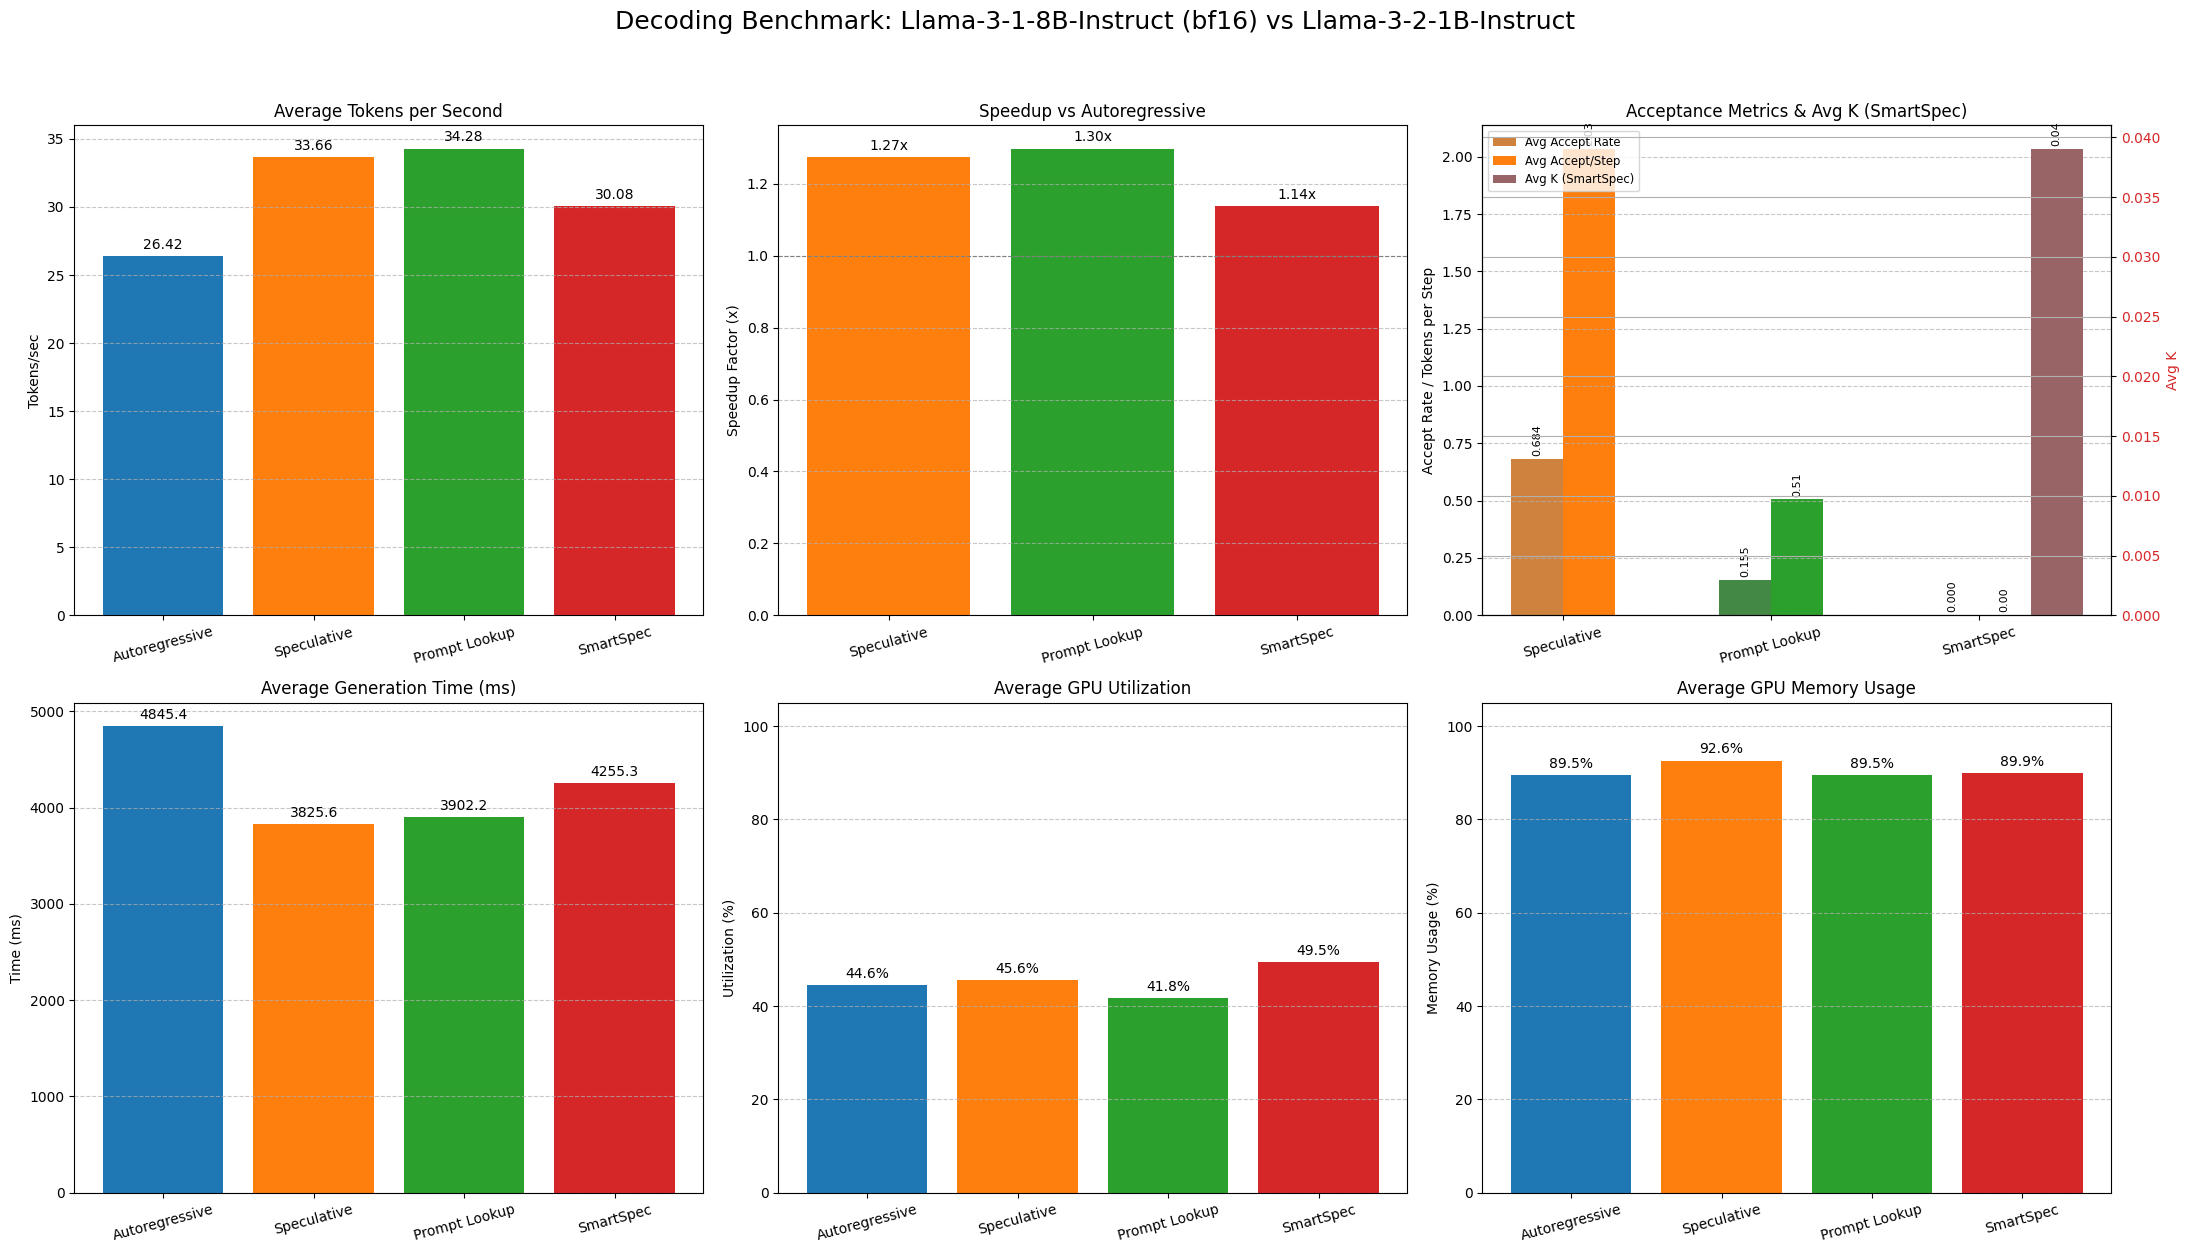


--- Main Benchmark Script Finished ---

--- Benchmark Results DataFrame Head ---
           Method  Time (s)  Tokens Generated  Tokens/Sec Acceptance Rate  \
0  Autoregressive  4.855773               128   26.360373             N/A   
1     Speculative  4.266028               128   30.004493        0.555556   
2   Prompt Lookup  4.434089               128   28.867260        0.080321   
3       SmartSpec  4.268176               128   29.989389             0.0   
4  Autoregressive  4.864784               128   26.311547             N/A   

  Avg Accepted/Step                  Gamma  Avg GPU Util %  Avg GPU Mem %  \
0               N/A                    N/A       43.300000      89.427551   
1          1.632653                      3       44.555556      92.018806   
2          0.185185  PLD (N=3, P=5, W=512)       42.000000      89.409214   
3               0.0                      3       48.333333      89.595846   
4               N/A                    N/A       45.300000      89.448

In [ ]:
# --- Execute the main runner ---
if __name__ == "__main__":
    print(f"[{time.strftime('%H:%M:%S')}] Executing main benchmark runner...")
    benchmark_dataframe = None
    # Define necessary global variables or ensure they are set by preceding cells/imports
    # Example placeholder definitions (replace with actual setup):
    # TARGET_MODEL_NAME = "gpt2"
    # DRAFT_MODEL_NAME = "gpt2" # or None
    # DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    # DTYPE = torch.float16 if DEVICE == 'cuda' else torch.float32
    # quantization_config = None
    # BENCHMARK_PROMPTS = ["Once upon a time", "The quick brown fox"]
    # BENCHMARK_MAX_NEW_TOKENS = 50
    # BENCHMARK_RUNS = 1
    # DEFAULT_TEMPERATURE = 0.0 # Set 0 for greedy
    # DEFAULT_TOP_K = 0
    # DEFAULT_TOP_P = 1.0
    # DEFAULT_GAMMA = 5
    # DEFAULT_MAX_NGRAM_SIZE = 3
    # DEFAULT_NUM_PRED_TOKENS = 5
    # CHECKPOINT_DIR = "./benchmark_results"
    # LOAD_IN_4BIT = False
    # LOAD_IN_8BIT = False
    # FLASH_ATTN_AVAILABLE = False # Set based on environment
    # HF_TOKEN = None # Set if needed

    # # --- Dummy Model/Tokenizer Loading (Replace with actual loading) ---
    # from transformers import AutoModelForCausalLM, AutoTokenizer
    # try:
    #     target_model = AutoModelForCausalLM.from_pretrained(TARGET_MODEL_NAME, torch_dtype=DTYPE).to(DEVICE)
    #     target_tokenizer = AutoTokenizer.from_pretrained(TARGET_MODEL_NAME)
    #     if DRAFT_MODEL_NAME:
    #         drafter_model = AutoModelForCausalLM.from_pretrained(DRAFT_MODEL_NAME, torch_dtype=DTYPE).to(DEVICE)
    #         drafter_tokenizer = AutoTokenizer.from_pretrained(DRAFT_MODEL_NAME)
    #     else: drafter_model, drafter_tokenizer = None, None
    # except Exception as load_e:
    #     print(colored(f"Error loading dummy models: {load_e}", "red"))
    #     target_model, target_tokenizer, drafter_model, drafter_tokenizer = None, None, None, None

    # # --- Dummy Decoder/Util Definitions (Replace with actual definitions) ---
    # class BaseDecoder:
    #      def __init__(self, model, tokenizer): self.model=model; self.tokenizer=tokenizer; self.device=model.device; self.eos_token_ids=[tokenizer.eos_token_id] if tokenizer.eos_token_id else []
    #      def generate(self, **kwargs): print(f"Dummy Generate called for {type(self).__name__}"); return [5,6,7], 0.1, {"Tokens/Sec": 10.0, "Tokens Generated": 3} # Dummy output
    # class AutoregressiveDecoder(BaseDecoder): pass
    # class SpeculativeDecoder(BaseDecoder):
    #     def __init__(self, target_config, draft_config): # Example config init
    #         print("Dummy SD init with config")
    #         # Need to actually load/assign models here based on config or pass preloaded
    #         super().__init__(target_model, target_tokenizer) # Use global dummy for now
    #         self.drafter_model=drafter_model; self.drafter_tokenizer=drafter_tokenizer; self.drafter_device=drafter_model.device if drafter_model else None
    # class PromptLookupDecoder(BaseDecoder): pass
    # class SmartSpecDecoder(SpeculativeDecoder):
    #     def set_coefficients(self, coeffs): print(f"Dummy SS set coeffs: {coeffs}")
    # class GPUMonitor:
    #      def start(self): pass
    #      def stop(self): pass
    #      def get_results(self): return [{"gpu_utilizations": [50.0], "gpu_memories": [30.0]}]
    #      def clear(self): pass
    #      def exit(self): pass
    # def ids_to_string(ids, tokenizer): return tokenizer.decode(ids) if tokenizer else "[no tokenizer]"
    # def calibrate_smartspec_coeffs_refined(d, t, dev): return {'draft_alpha': 0.5, 'draft_gamma_eff': 0.6, 'target_gamma_verify': 0.7, 'target_delta_verify': 0.8}

    # # --- END DUMMY SETUP ---

    try:
        benchmark_dataframe = main_benchmark_runner()

        if benchmark_dataframe is not None and not benchmark_dataframe.empty:
            print(colored("\n--- Benchmark Results DataFrame Head ---", "cyan"))
            with pd.option_context('display.max_rows', 5, 'display.max_columns', 20):
                 print(benchmark_dataframe.head())
        elif benchmark_dataframe is not None: print(colored("Benchmark ran but produced an empty results dataframe.", "magenta"))

    except NameError as ne:
        print(colored(f"\n--- A NameError Occurred ---", "red")); print(f"ERROR: {ne}")
        print("Please ensure all preceding cells are executed, including class/function definitions for models, decoders (AR, SD, PLD, SmartSpec), utilities, and calibration.")
        traceback.print_exc()
    except Exception as main_exec_e:
        print(colored(f"\n--- An Unexpected Error Occurred During Main Execution ---", "red")); print(f"ERROR: {main_exec_e}")
        traceback.print_exc()

    print(f"[{time.strftime('%H:%M:%S')}] Main script execution finished.")